# Projektmappe - Grab, Klöble, Ricker

Innerhalb der folgenden Projektmappe gehen wir nach dem CRISP-DM Standardprozess vor, der sich in die folgenden Schritte unterteilt und iterativ erfolgt.

1. [Business Understanding](#1-business-understanding)
2. [Data Understanding](#2-data-understanding)
3. [Data Preparation](#3-data-preparation)
4. [Modeling](#4-modeling)
5. [Evaluation](#5-evaluation)
6. [Deployment](#6-deployment)

Weitere Details lassen sich in unserer Dokumentation finden.

## 0. Import aller benötigten Bibliotheken und Daten

Zunächst werden jedoch alle benötigten Bibliotheken und Daten importiert, sodass folgend mit diesen gearbeitet werden kann.

In [1]:
# Installieren der Bibliotheken:

%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
# Importieren der Bibliotheken:

import importlib
from Anforderungen import init_notebook

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC, SVC

c:\Users\SebastianGrab\OneDrive - DESIGNated Accessoires UG\Desktop\DataAnalytics\Projekt\Anforderungen\init_notebook.py:13: SyntaxWarning: invalid escape sequence '\P'
  file_path = str(os.getcwd()).split("\Projekt")


In [3]:
# Laden des Datasets:

    # Dateipfad aufrufen:

file_path = str(os.getcwd()).split("\Projekt")
file_path = file_path[0] + '\\Projekt\\Daten'


    # Datei laden, wenn sie vorhanden ist:

if os.path.exists(file_path + '\\smoking_driking_dataset_Ver01.csv'):

    dataset = pd.read_csv(file_path + '\\smoking_driking_dataset_Ver01.csv')

else:
    print('Die Datei "smoking_driking_dataset_Ver01.csv" existiert nicht im Ordnerpfad ./Projekt/Daten' )

<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
C:\Users\SebastianGrab\AppData\Local\Temp\ipykernel_23368\3807963942.py:5: SyntaxWarning: invalid escape sequence '\P'
  file_path = str(os.getcwd()).split("\Projekt")


## 1. Business Understanding

Zum bisherigen Zeitpunkt werden Patienten anhand einer Vielzahl von Kriterien in verschiedene Kohorten eingeteilt. 

Das Ermitteln der Ausprägungen dieser Kriterien bei den einzelnen Patienten ist jedoch sehr kostspielig, insbesondere wenn es um die Abfrage von Blutbildparametern geht. Jeder Parameter verursacht Kosten, und die Anzahl der Parameter beeinflusst die Bearbeitungszeit im Labor. Daraus ergibt sich das Ziel, die Anzahl der abgefragten Kriterien zu reduzieren, um sowohl Kosten als auch Zeit zu sparen, ohne dabei die Qualität der Kohorteneinteilung zu beeinträchtigen. 

Nach Analysen des Robert Koch-Instituts ([Quelle](https://www.rki.de/DE/Content/Gesundheitsmonitoring/Themen/Rauchen/Rauchexposition_epidstudien.html)) wird davon ausgegangen, dass der Raucherstatus das bedeutendste Kriterium für die Bestimmung des Gesundheitsrisikos und somit auch für die Kohorteneinteilung ist. 

Deshalb wird in der folgenden Projektmappe, einem Jupyter Notebook, versucht, die Anzahl der Kriterien zu minimieren, indem lediglich Features selektiert werden, die mit dem Raucherstatus korrelieren. Dadurch können Algorithmen trainiert werden, die die gegebene Antwort der Patienten auf die Frage des Raucherstatus validieren sollen.

## 2. Data Understanding



In [4]:
# Ausgabe der Daten:

dataset.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


Zur weiteren Arbeit mit dem Datensatz bietet es sich an, dessen Spalten in aussagekräftigere Titel umzubenennen.

In [5]:
# Umbenennen der Spalten in aussagekräftigere Benennungen und in Deutsch:

dataset = dataset.rename(columns={'sex': 'Geschlecht', 'age': 'Alter', 'height': 'Größe', 'weight': 'Gewicht', 'waistline': 'Hüftumfang', 'sight_left': 'Sehkraft_links', 'sight_right': 'Sehkraft_rechts', 'hear_left': 'Hörkraft_links', 'hear_right': 'Hörkraft_rechts', 'SBP': 'Systolischer Blutdruck', 'DBP': 'Diastolischer Blutdruck', 'BLDS': 'Nüchterner Blutzucker', 'tot_chole': 'Totale Cholesterin', 'HDL_chole': 'HDL_Cholesterin', 'LDL_chole': 'LDL_Cholesterin', 'triglyceride': 'Triglycerid', 'hemoglobin': 'Hämoglobin', 'urine_protein': 'Urin_Proteine', 'serum_creatinine': 'Serum_Kreatinin', 'SGOT_AST': 'SGOT_AST', 'SGOT_ALT': 'SGOT_ALT', 'gamma_GTP': 'gamma_GTP', 'SMK_stat_type_cd': 'Raucher_Status', 'DRK_YN': 'Trinker'})

Mit der Funktion check_df wird ein Überblick über den Datensatz erzeugt. 

In unserer Dokumentation findet sich im Anhang "Details zum Datensatz" eine tabellarische Darstellung der einzelnen Spalten zusammen mit entsprechenden Erläuterungen. 

Alle entsprechenden Erkenntnisse werden im Abschnitt "Data Understanding & Data Preparation" erläutert. 

In [6]:
# Funktion zur Darstellung von Informationen über den Datensatz: 

def check_df(dataset):
    print("##################### Shape #####################")
    print(dataset.shape)
    print("\n##################### Types #####################")
    print(dataset.dtypes)
    print("\n##################### NA #####################")
    print(dataset.isnull().sum())
    print("\n##################### Missing #####################")
    print(dataset.isnull().any())
    print("\n##################### Duplicated Rows #####################")
    print(dataset.duplicated().sum())
    print("\n##################### Quantiles #####################")
    print(dataset.describe().T)
    print("\n##################### Number of Unique Values #####################")
    for col in dataset.columns:
        print(col, dataset[col].nunique())


check_df(dataset)

##################### Shape #####################
(991346, 24)

##################### Types #####################
Geschlecht                  object
Alter                        int64
Größe                        int64
Gewicht                      int64
Hüftumfang                 float64
Sehkraft_links             float64
Sehkraft_rechts            float64
Hörkraft_links             float64
Hörkraft_rechts            float64
Systolischer Blutdruck     float64
Diastolischer Blutdruck    float64
Nüchterner Blutzucker      float64
Totale Cholesterin         float64
HDL_Cholesterin            float64
LDL_Cholesterin            float64
Triglycerid                float64
Hämoglobin                 float64
Urin_Proteine              float64
Serum_Kreatinin            float64
SGOT_AST                   float64
SGOT_ALT                   float64
gamma_GTP                  float64
Raucher_Status             float64
Trinker                     object
dtype: object

##################### NA ######

Aus dieser Darstellung lassen sich bereits einige auffällige Datenpunkte identifizieren:

- Ein Hüftumfang von 999 cm scheint nicht plausibel zu sein.
- Die maximalen Werte der Spalten Sehkraft_links und Sehkraft_rechts weichen stark vom Mittelwert ab.
- Der maximale Wert der Spalte Nüchterner Blutzucker weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte Totale Cholesterin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte HDL_Cholesterin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte LDL_Cholesterin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte Triglycerid weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte Serum_Kreatinin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte SGOT_AST weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte SGOT_ALT weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte gamma_GTP weicht stark vom Mittelwert ab.


- Die Spalten Trinker & Geschlecht sind vom Datentyp 'object'
- Es gibt keine Spalte, die als Identifier dient.

Diese werden im Abschnitt '3. Data Preparation' bereinigt.

Zudem bietet es sich an, die Ausprägungen der einzelnen Spalten auch visuell darzustellen, um ein besseres Verständnis der Daten zu erlangen.

Aus Anschaulichkeitsgründen werden Spalten mit weniger oder gleich 30 einzigartigen Werten als Bar-Chart und alle anderen Spalten als Boxplot visualisiert.

In [7]:
# Funktion zum Darstellen der Verteilung der Werte einer Spalte als Bar-Chart:

def bar_chart(column):
    share = (dataset[column].sort_values().value_counts(sort=False) / len(dataset)) * 100 
    plt.figure(figsize=(18, 6)) 
    share.plot(kind='bar') 
    plt.xlabel(share) 
    plt.ylabel('Prozentuale Häufigkeit')
    plt.grid(axis='y') 
    plt.show()

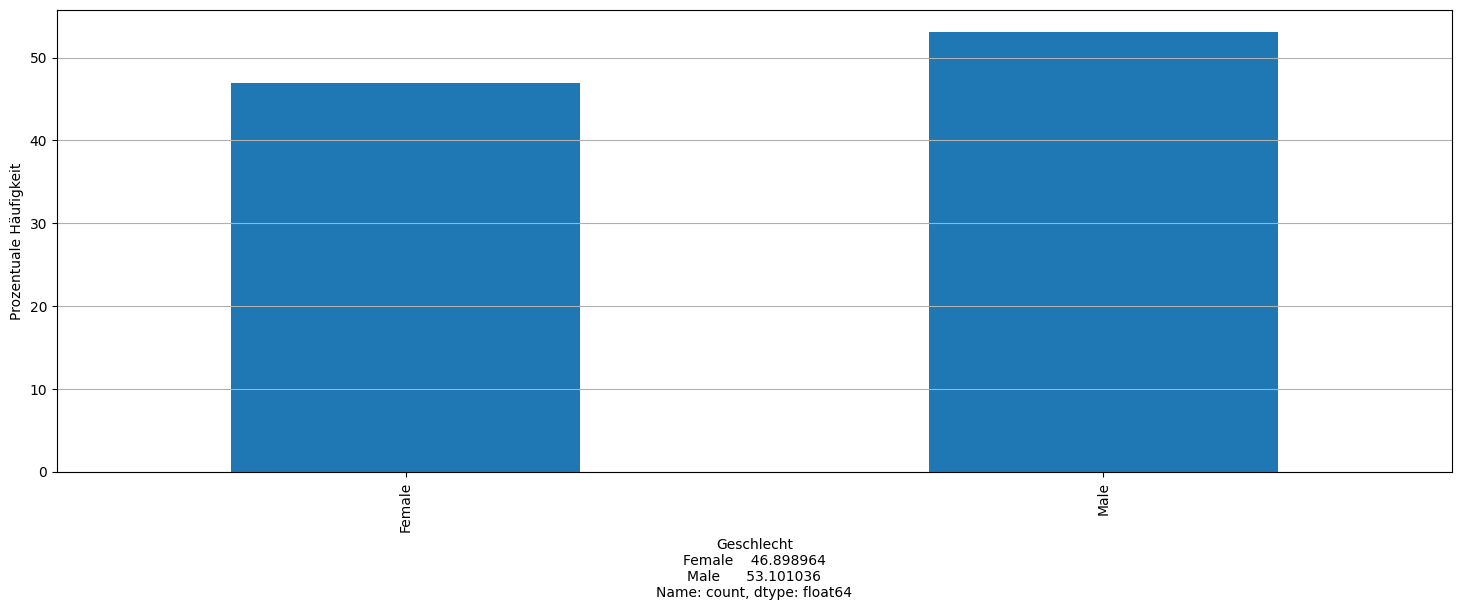

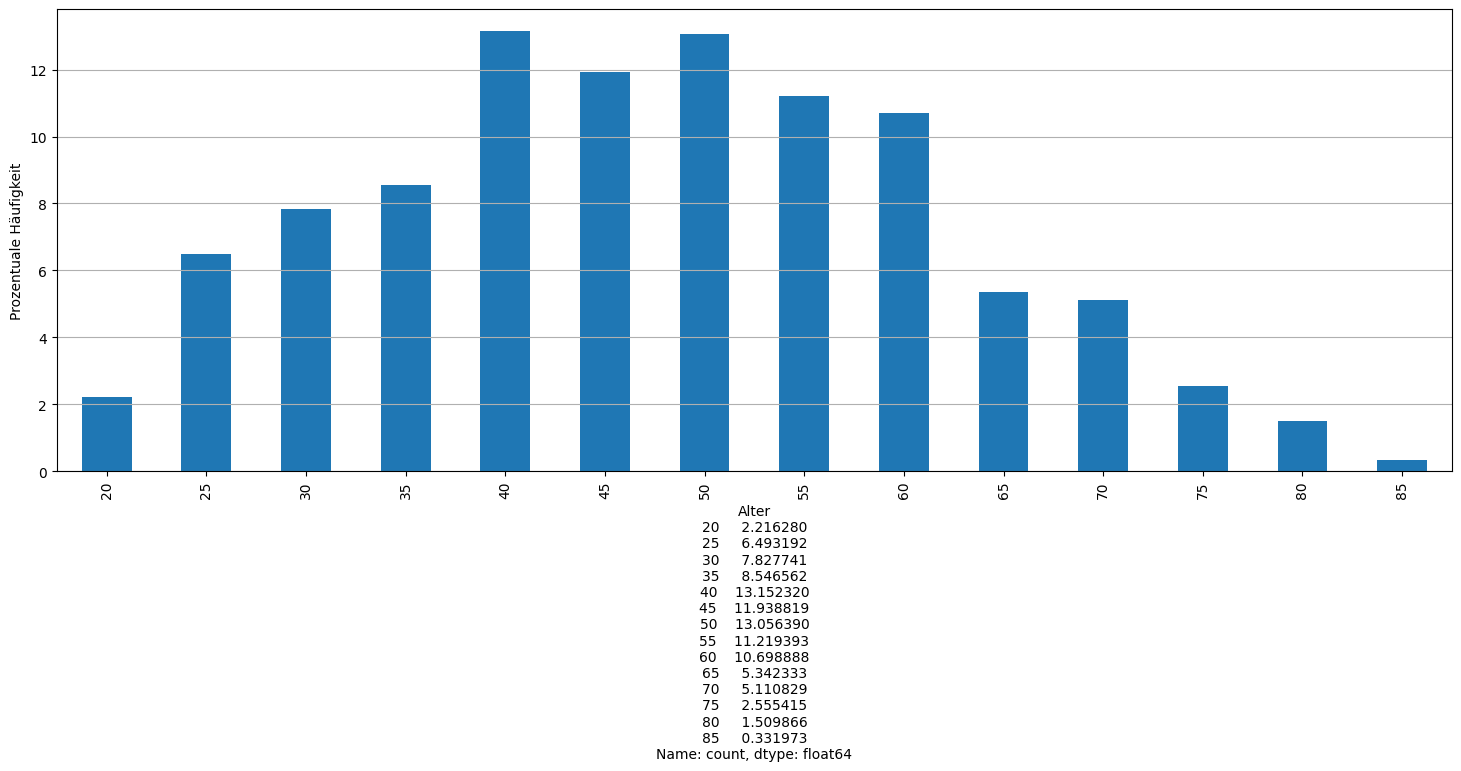

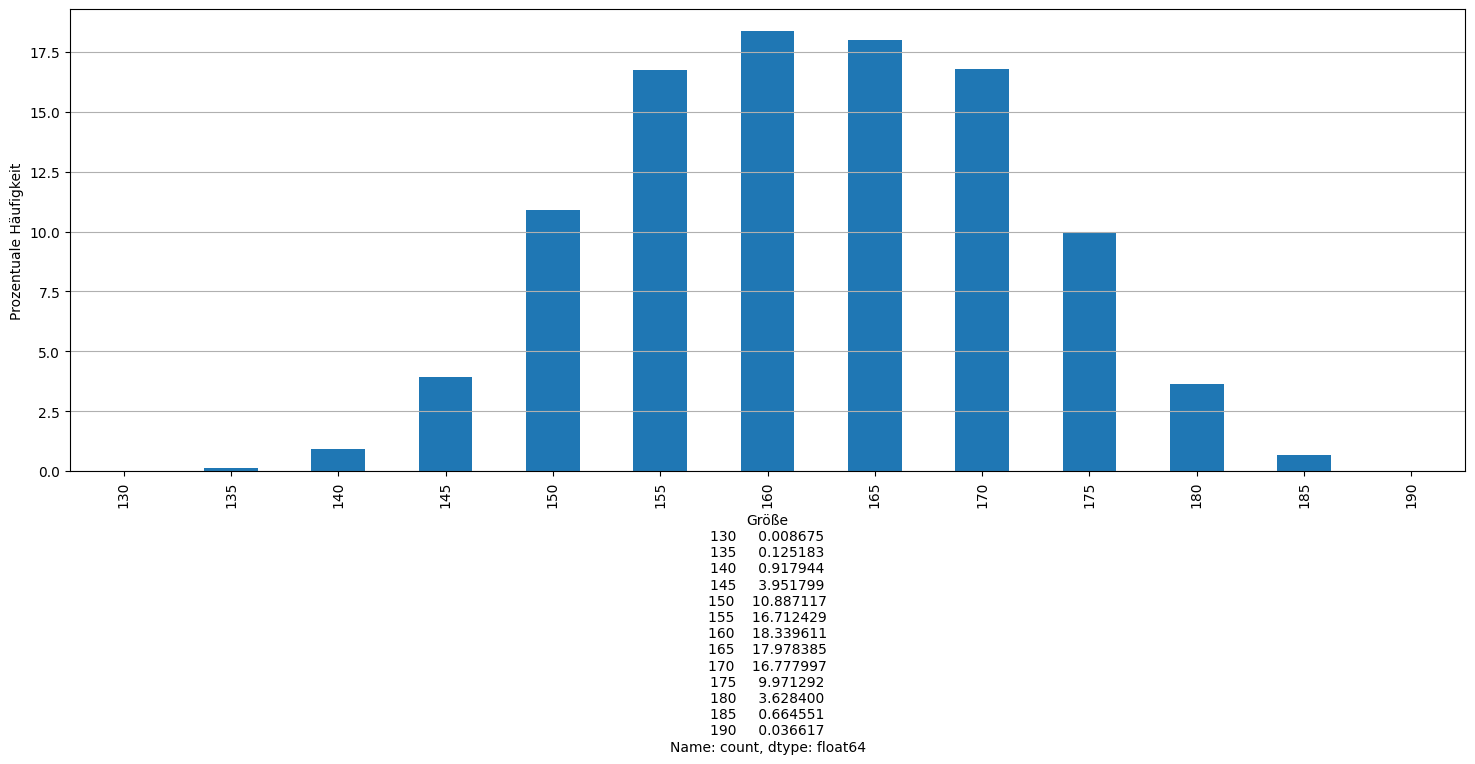

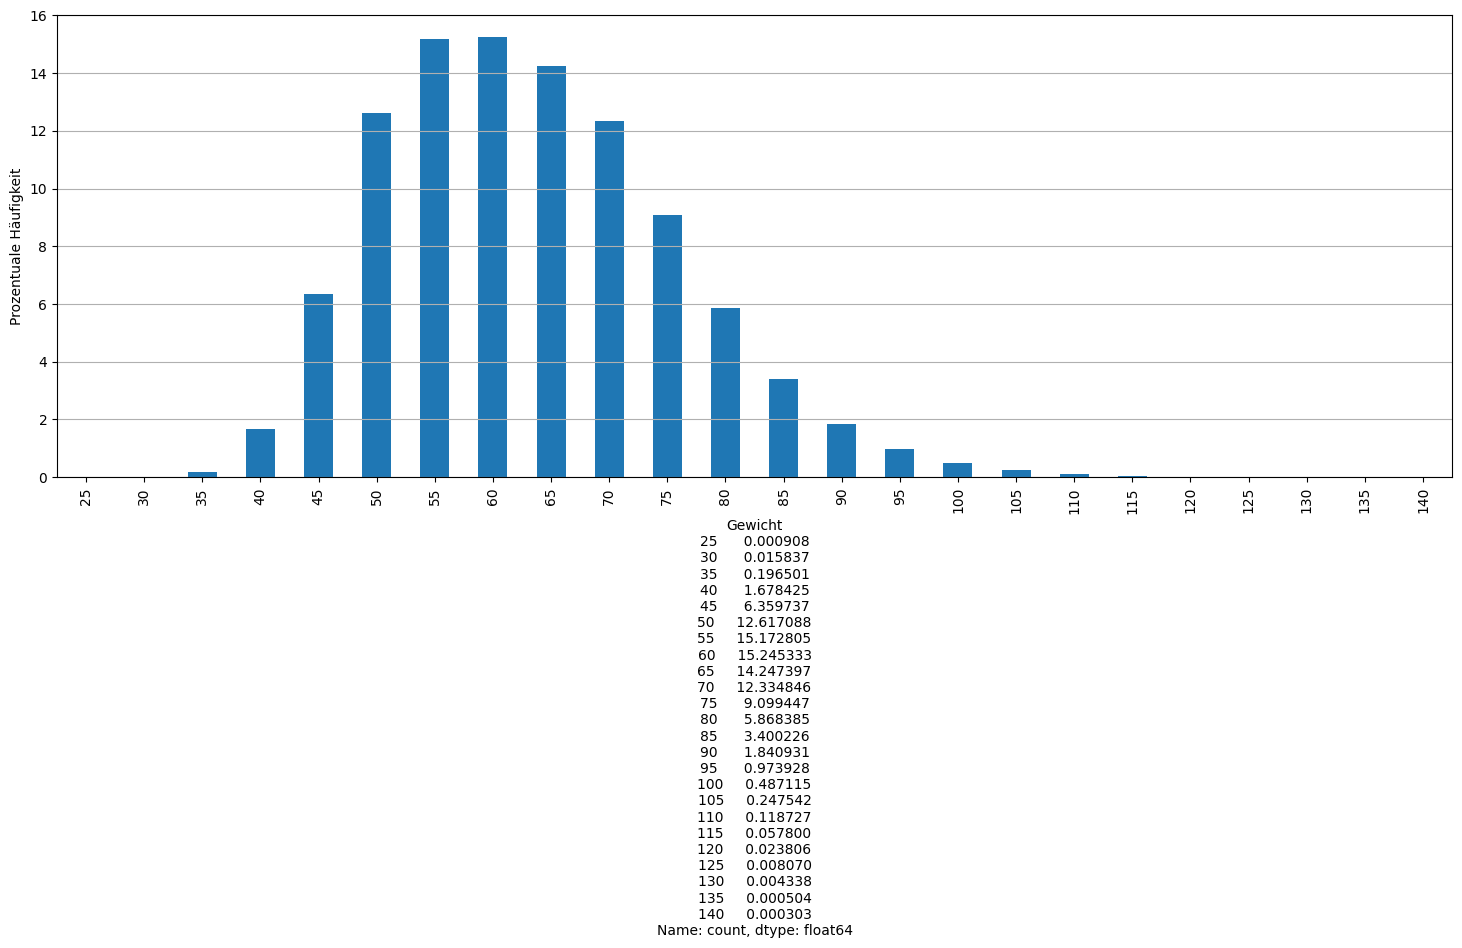

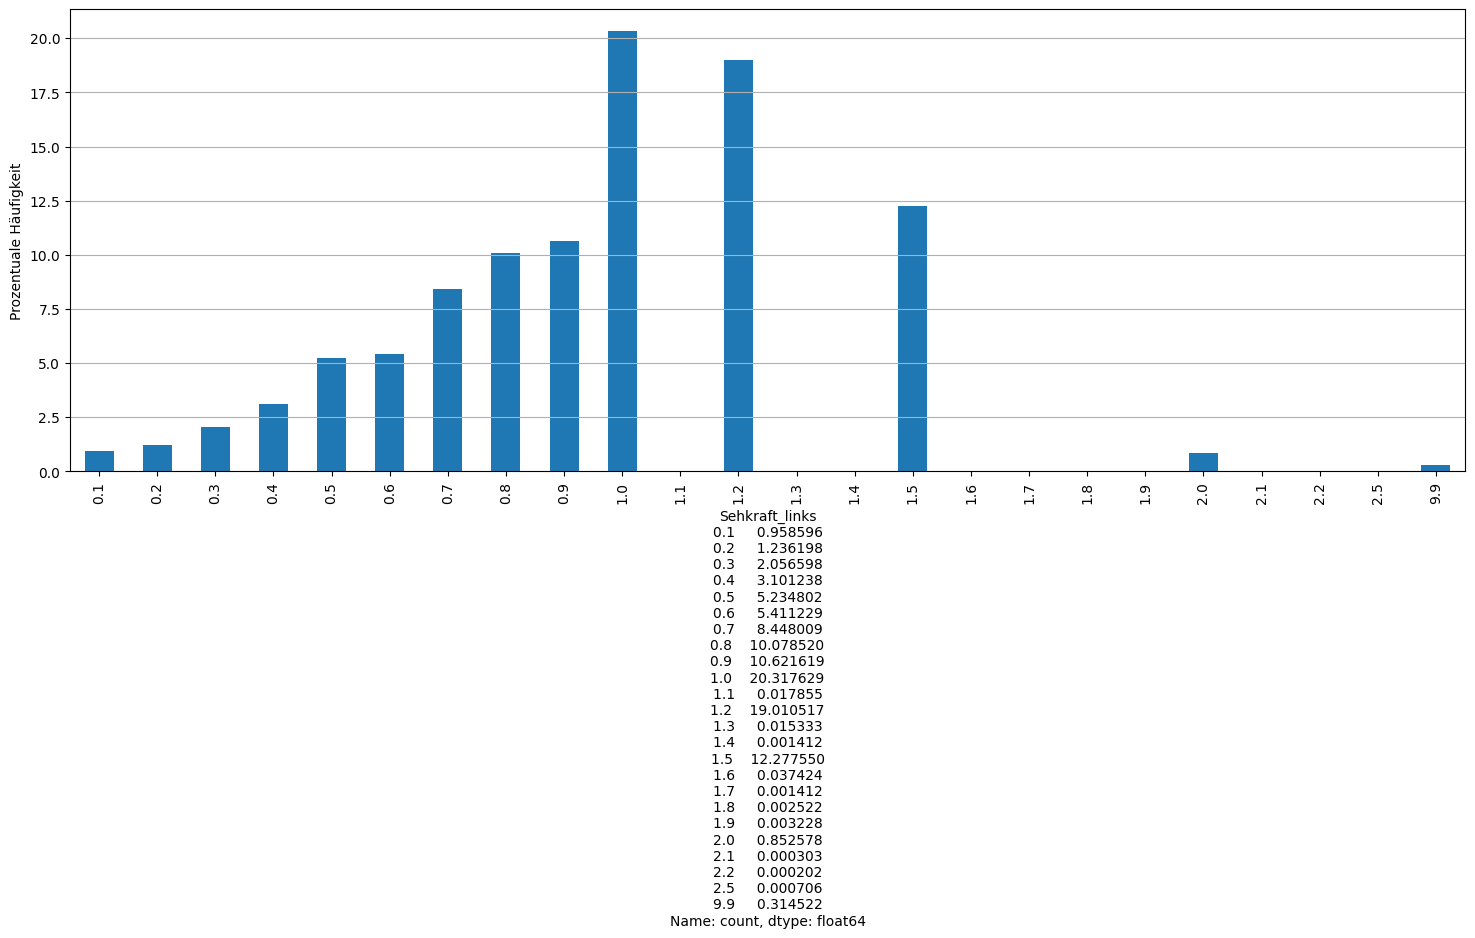

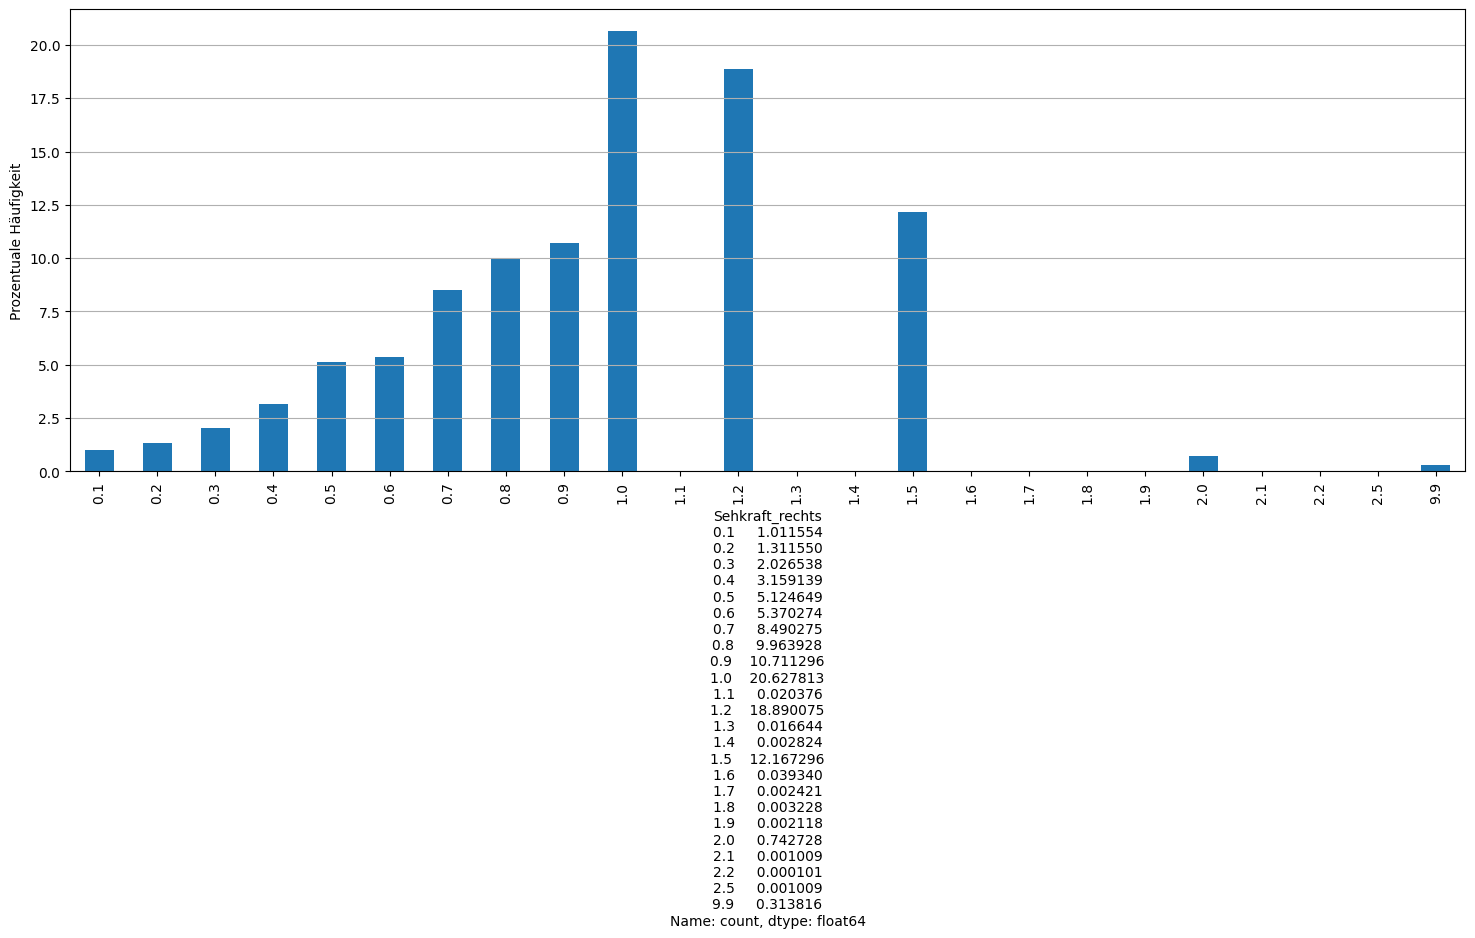

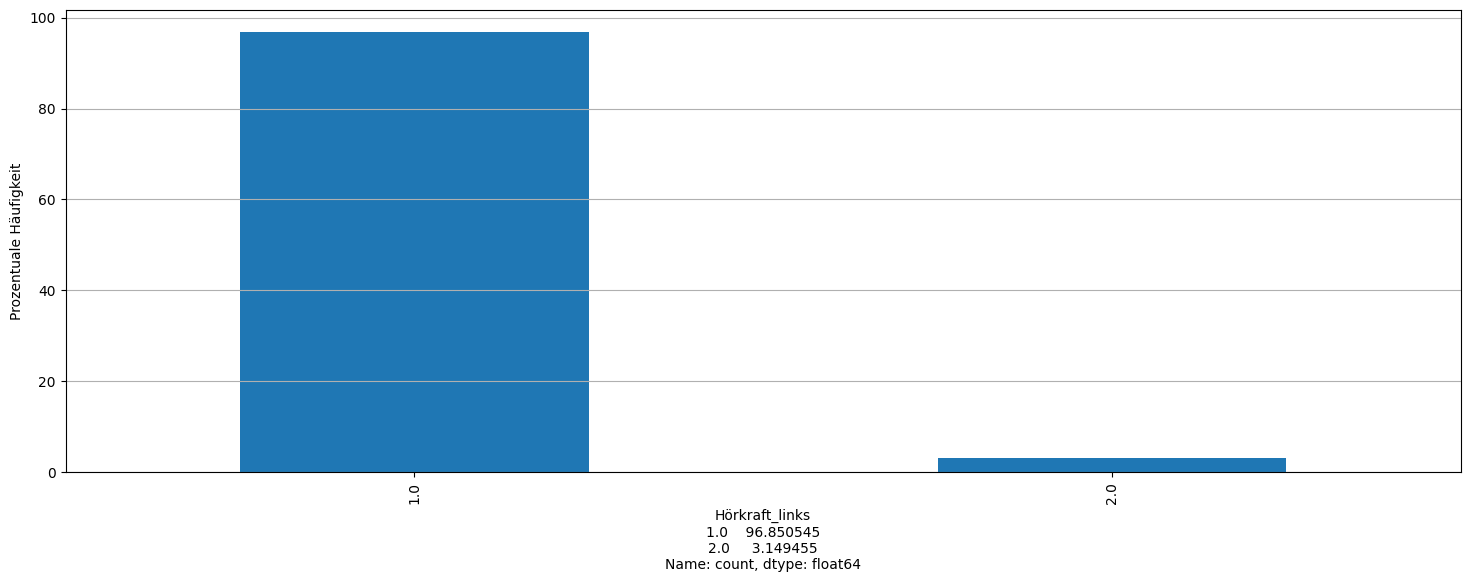

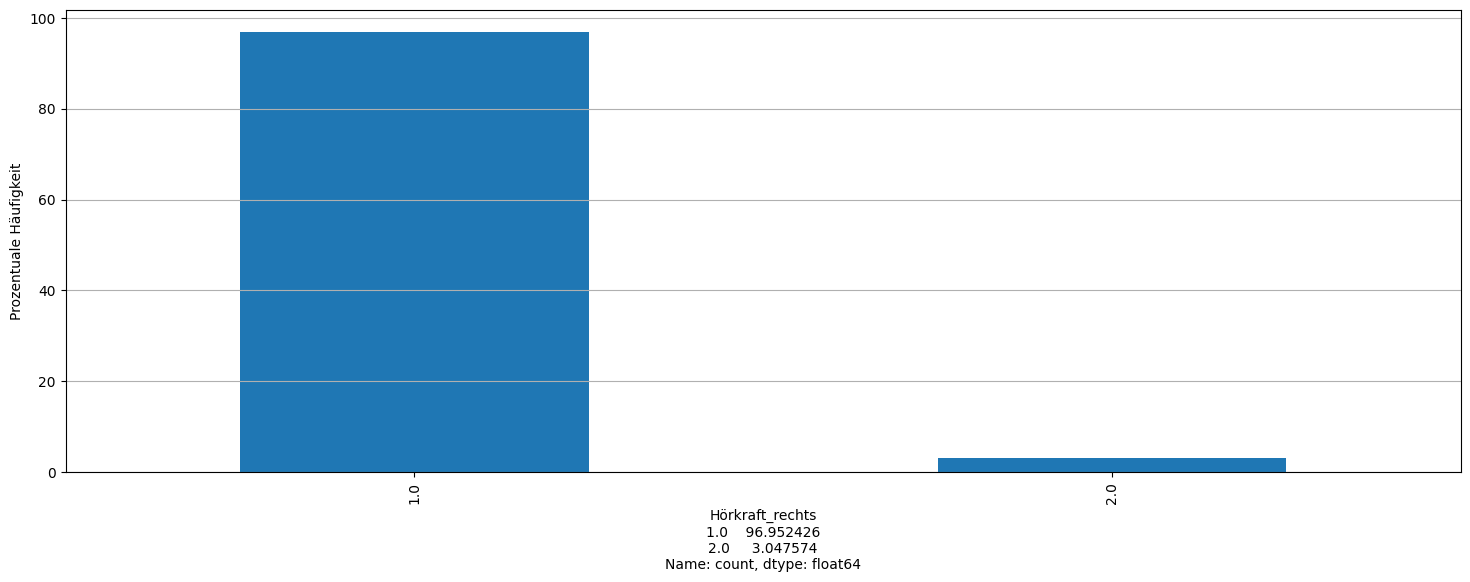

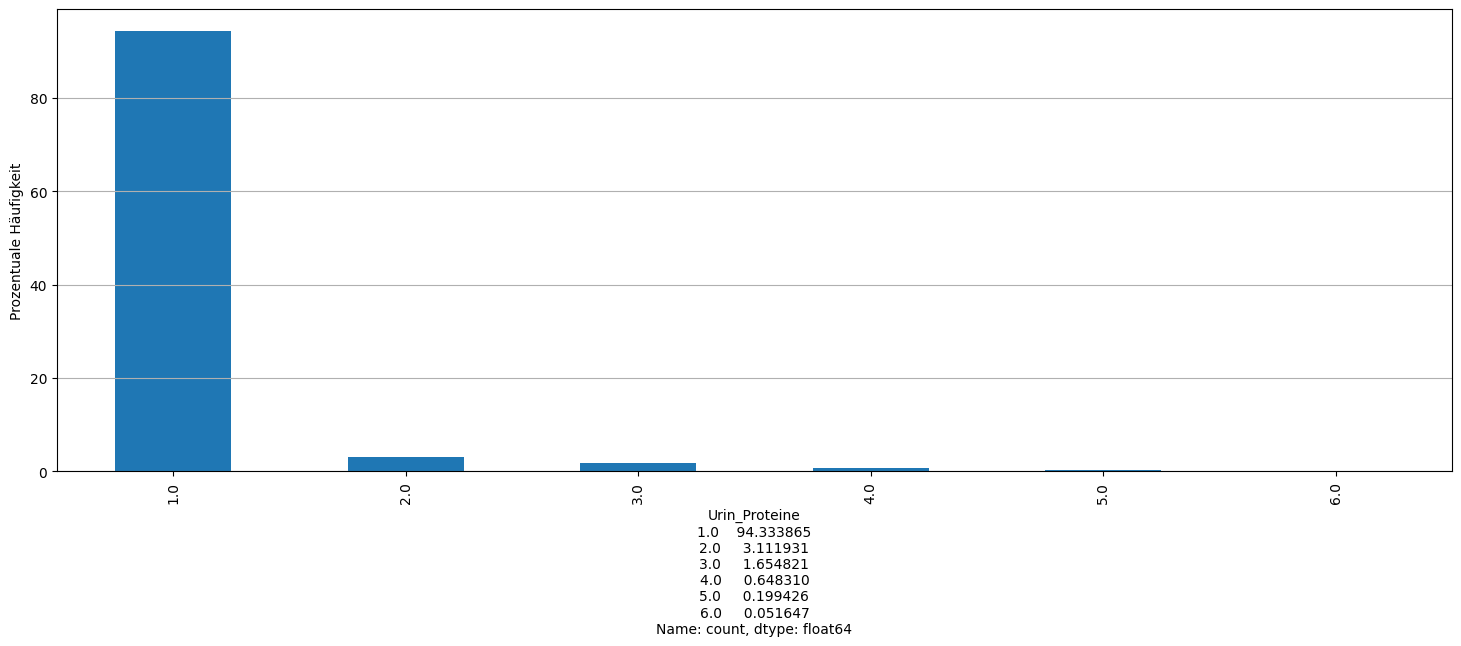

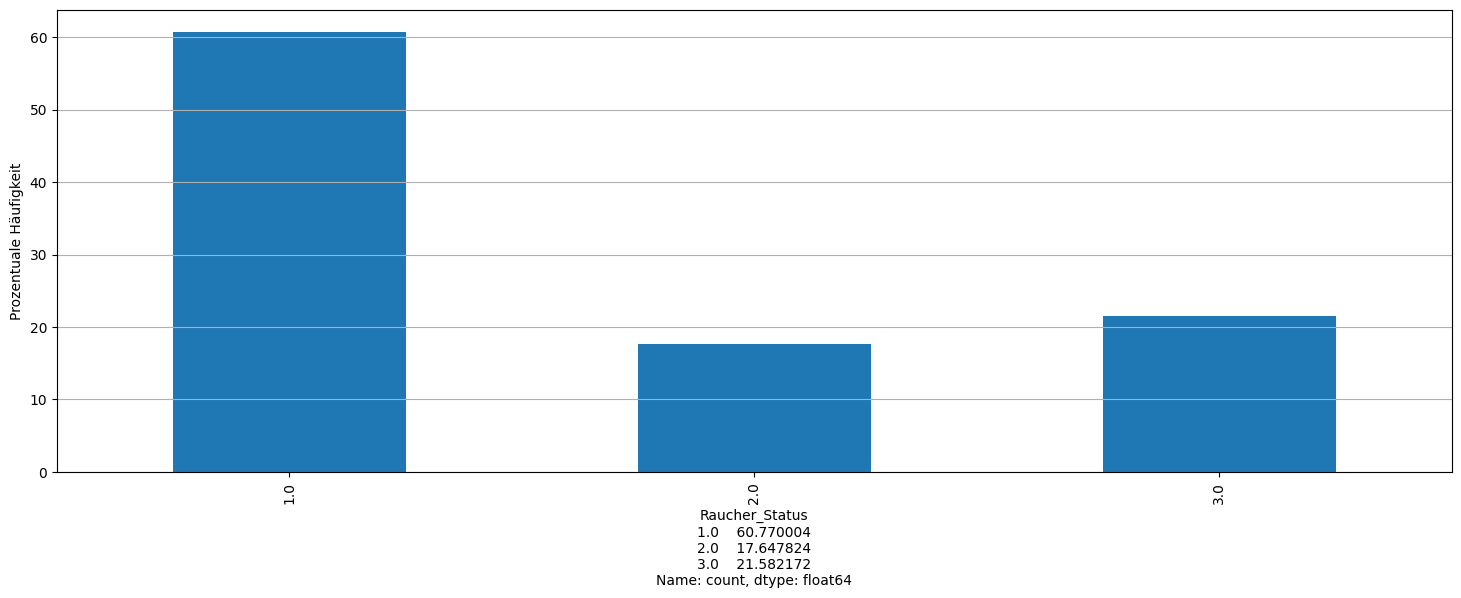

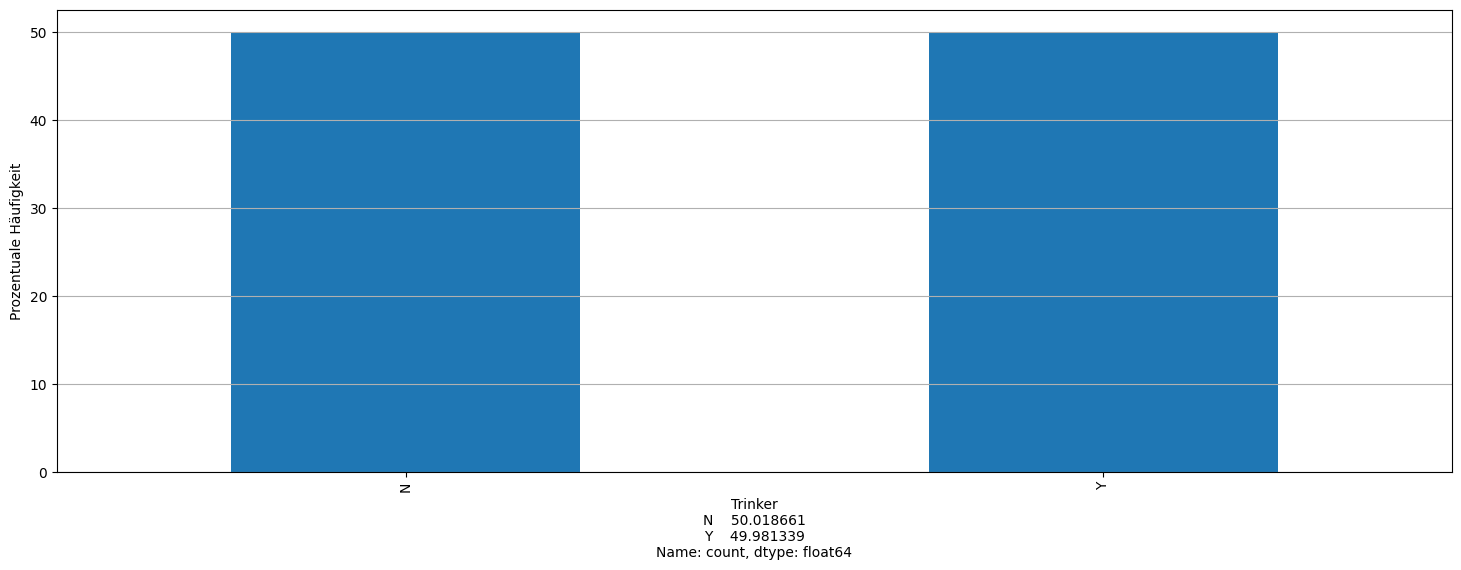

In [8]:
# Darstellen der Verteilung der jeweiligen Spalten:

    # Filtern der Spalten, die weniger oder gleich 30 unterschiedliche Werte enthalten:

dataset_columns_less = dataset.loc[:, dataset.apply(pd.Series.nunique) <= 30]


column_names_less = dataset_columns_less.columns.values.tolist()

for column in column_names_less:
    bar_chart(column)

In [9]:
# Funktion zum Darstellen der Verteilung der Werte einer Spalte als Boxplot:

def boxplot_chart(column):
    plt.figure(figsize=(18, 6)) 
    plt.boxplot(dataset[column], vert=False)
    plt.xlabel(column)
    plt.title('Boxplot')
    plt.show()

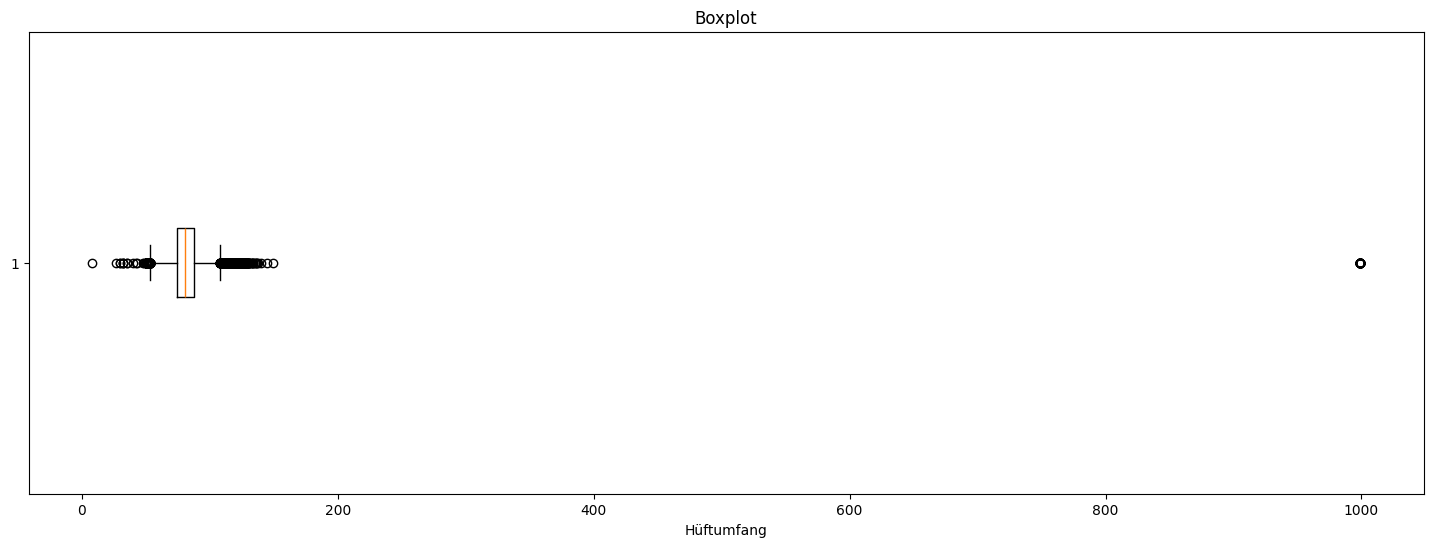

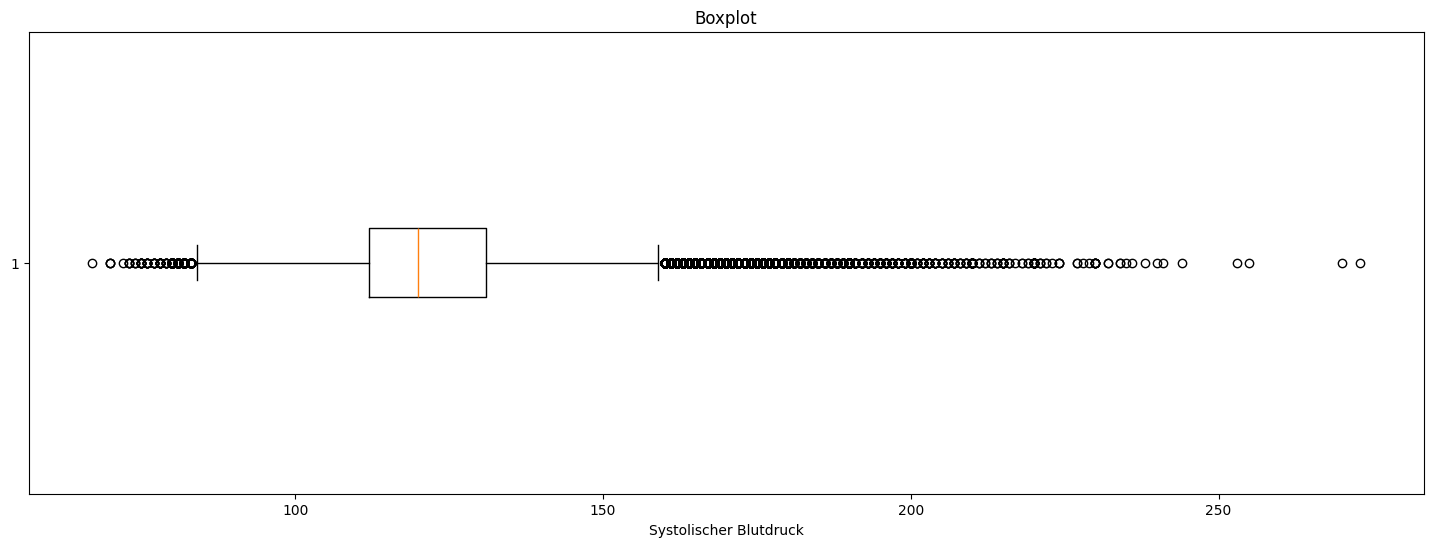

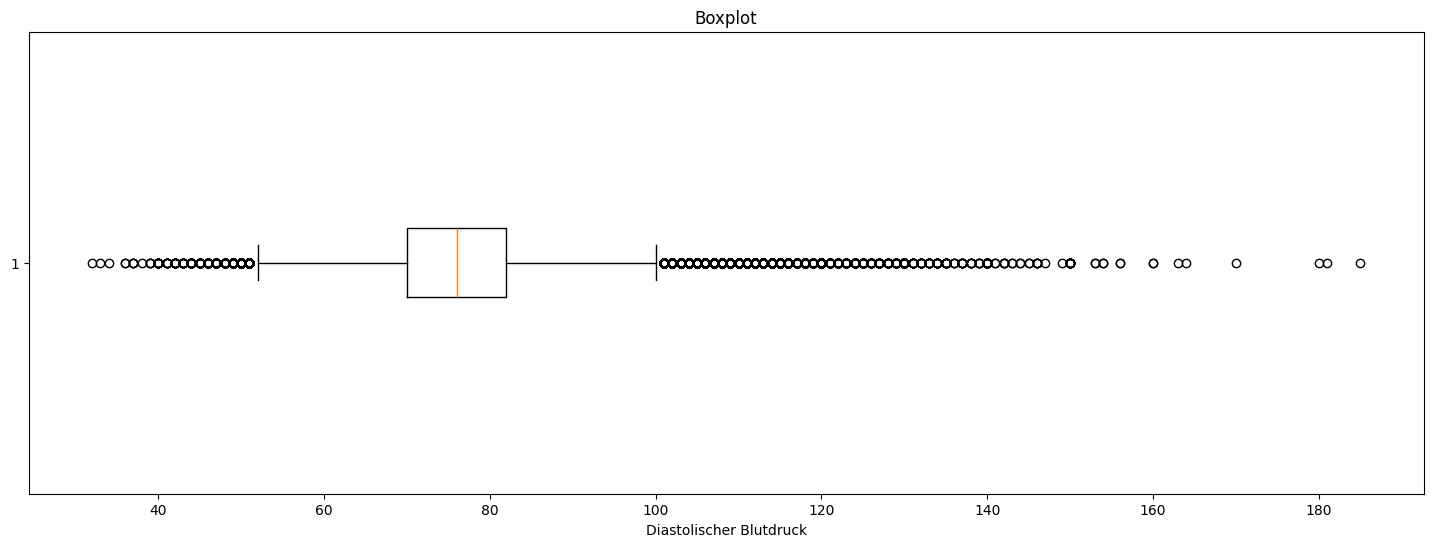

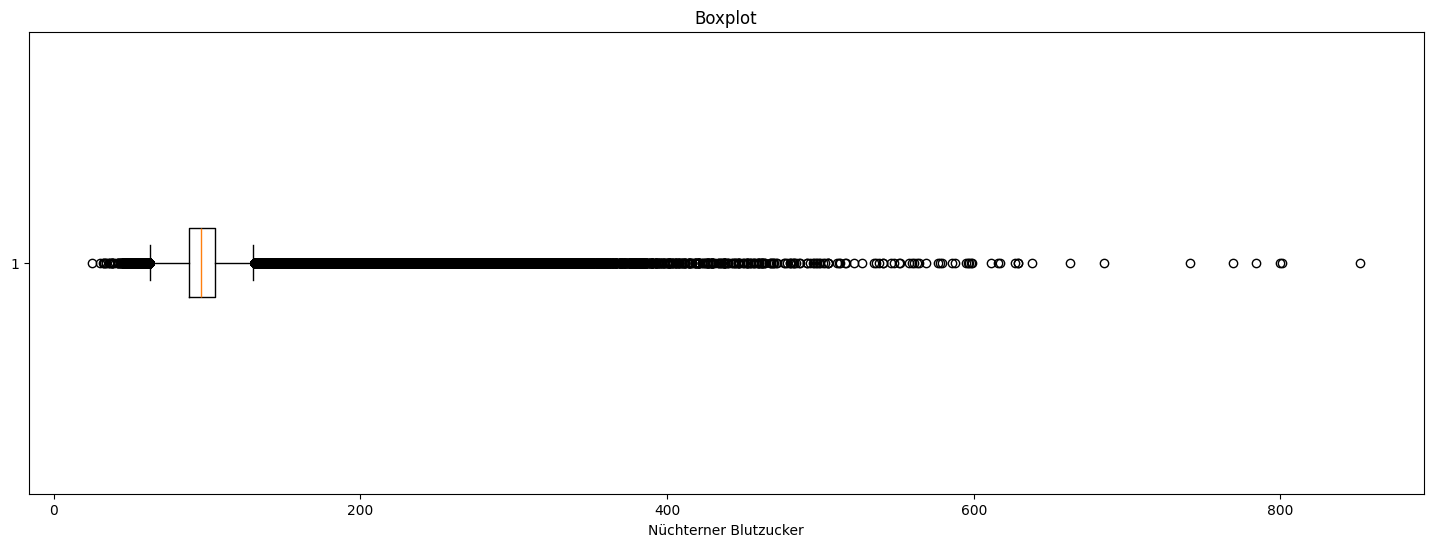

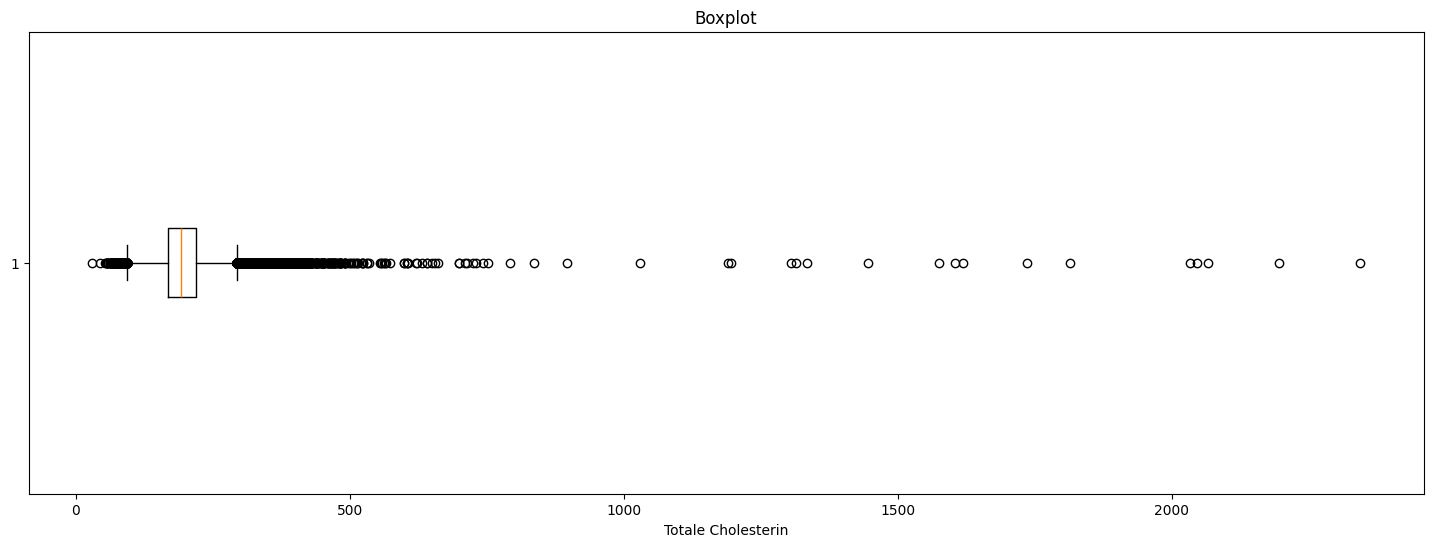

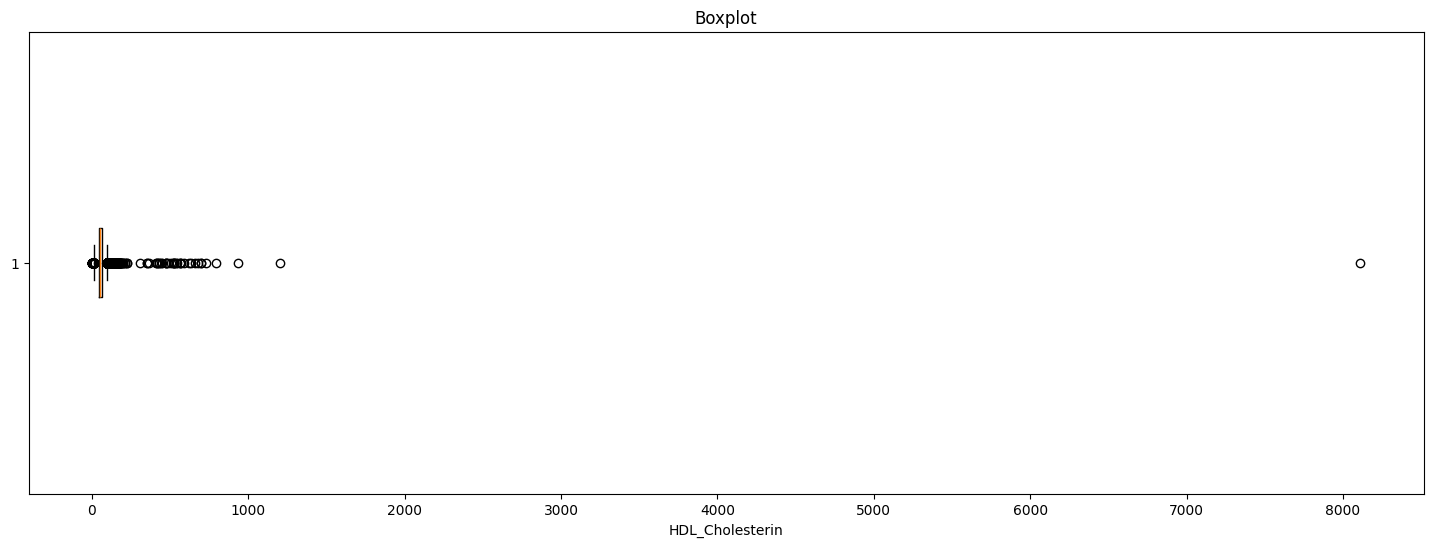

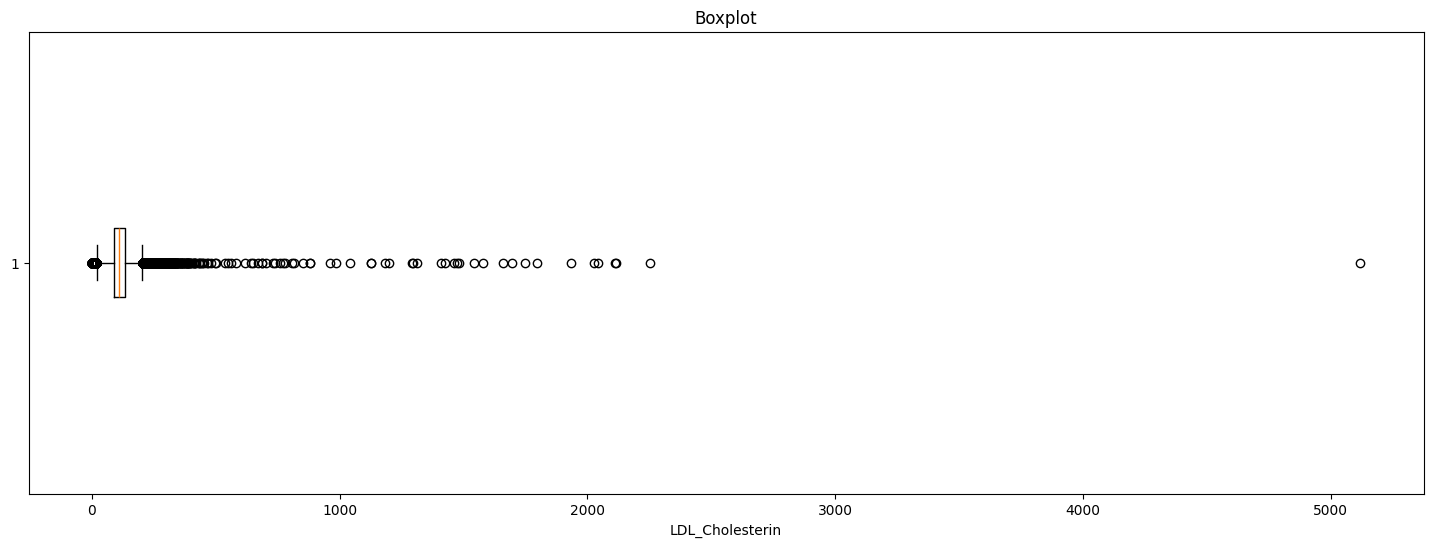

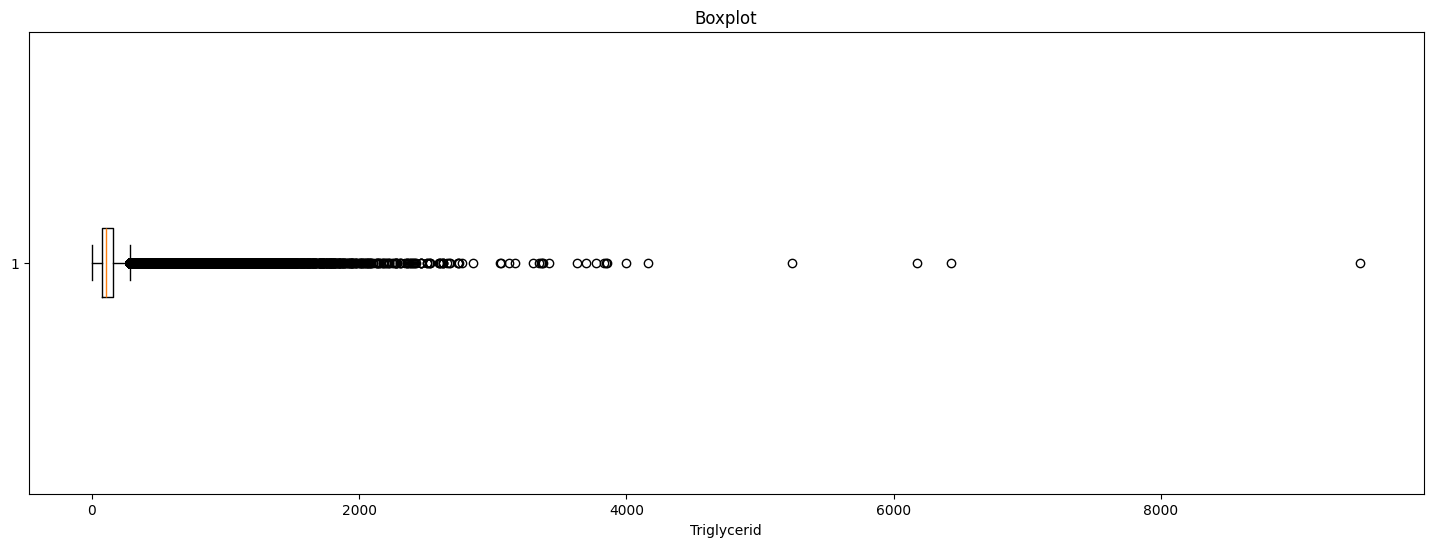

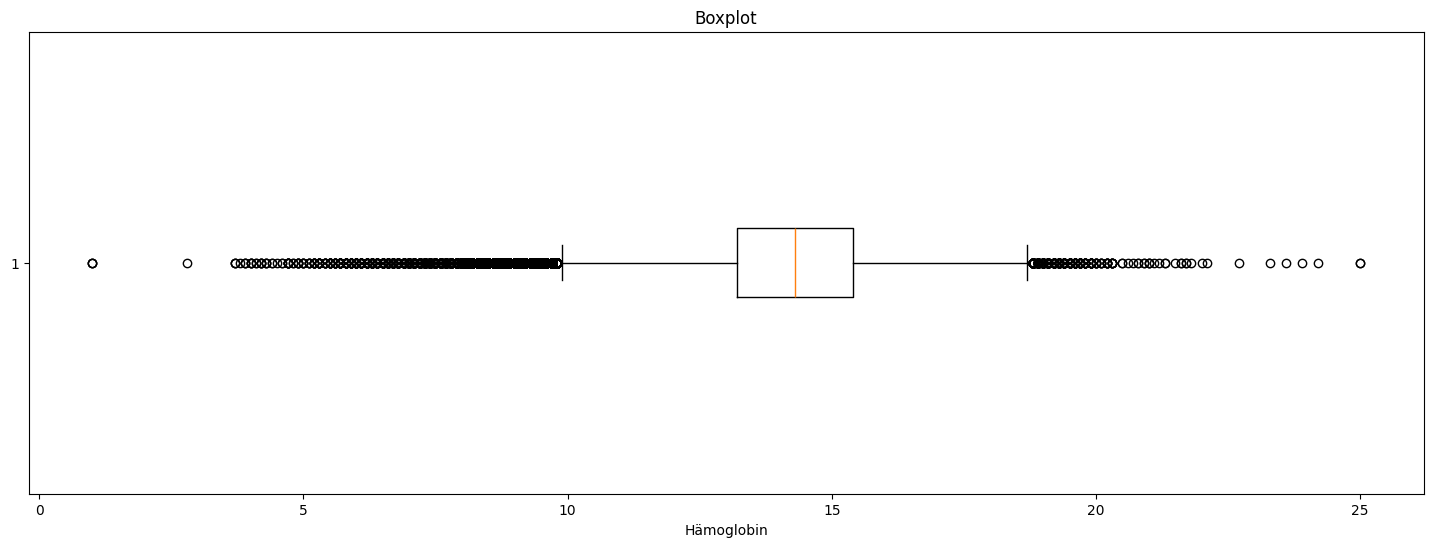

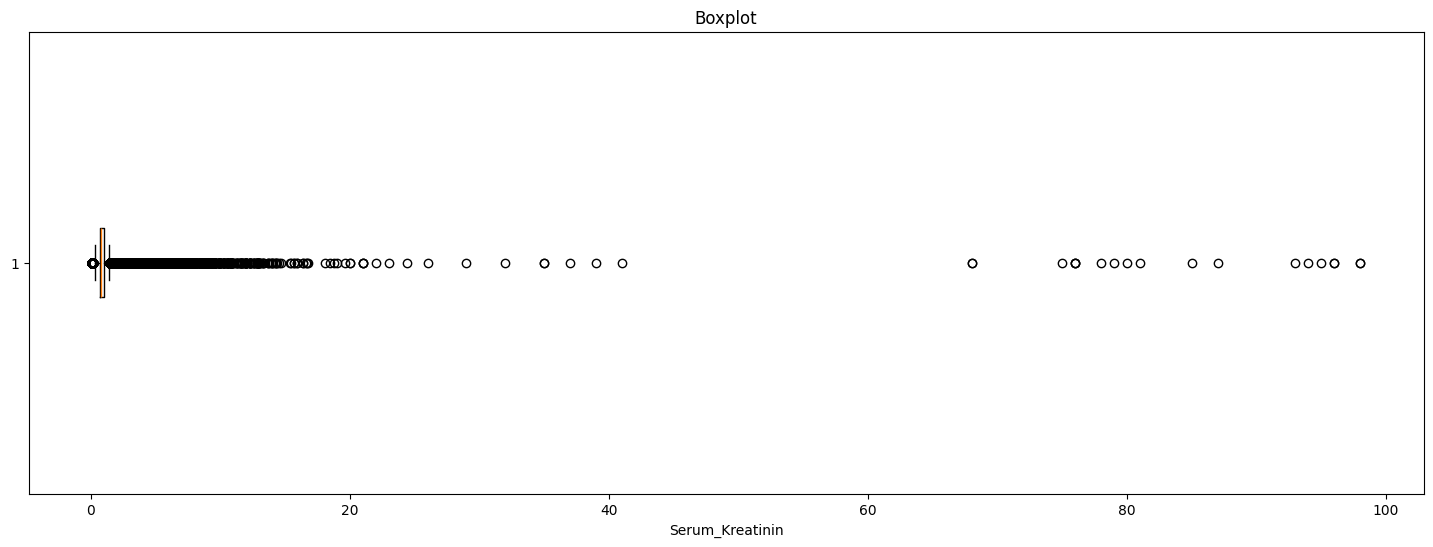

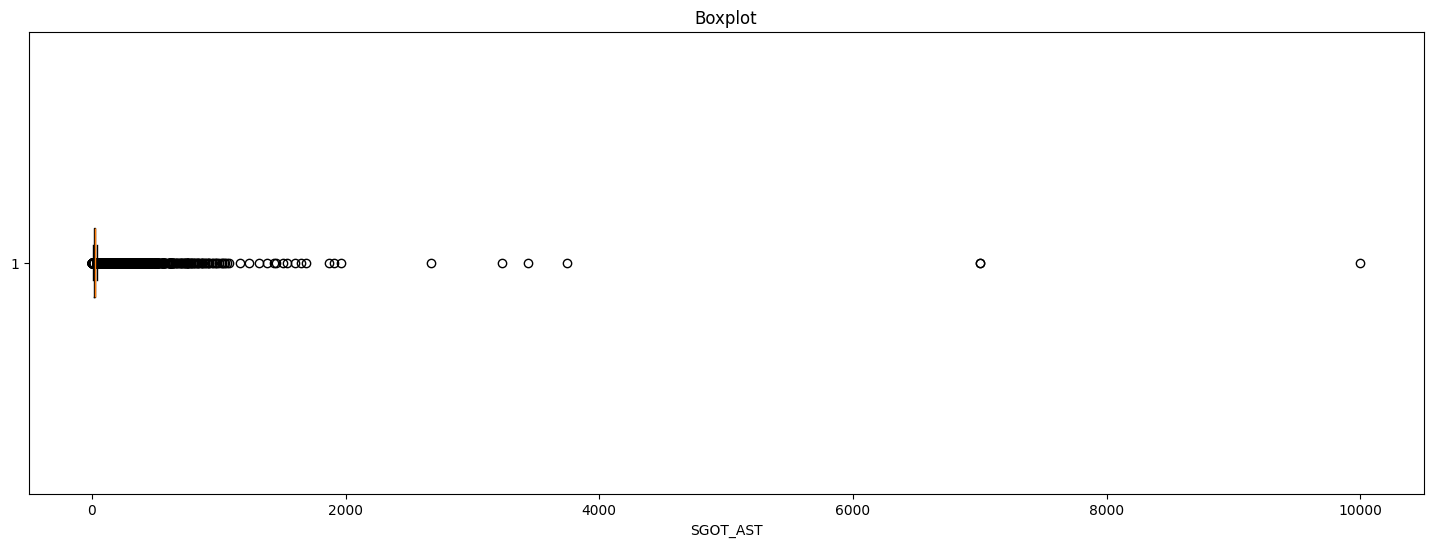

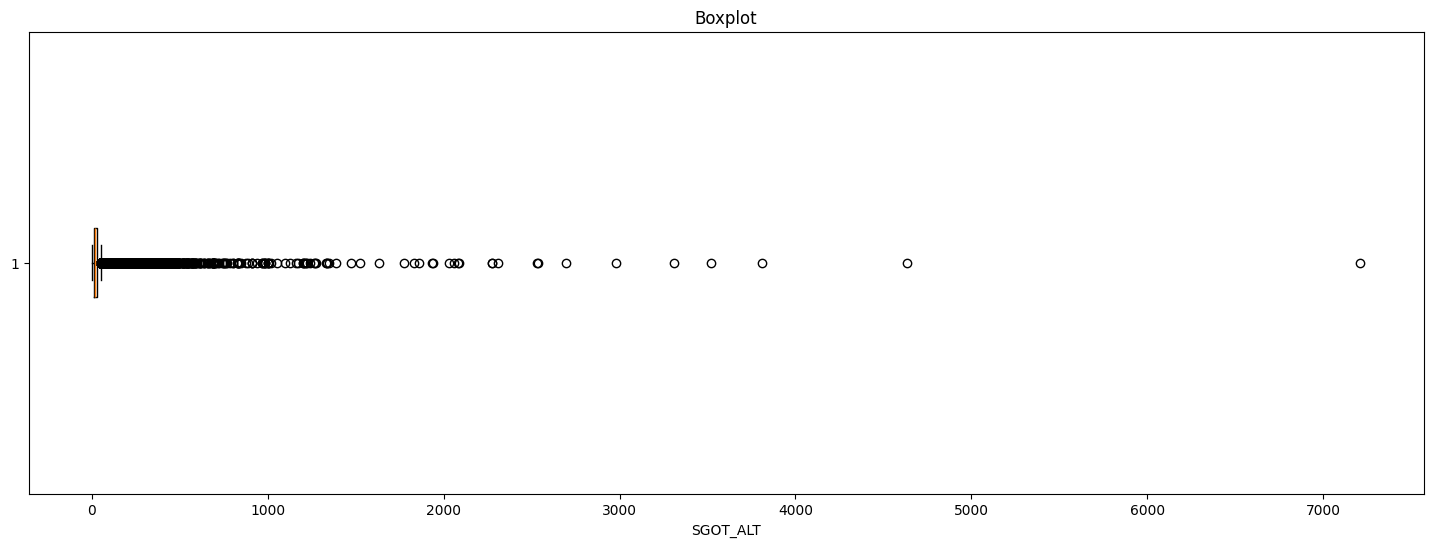

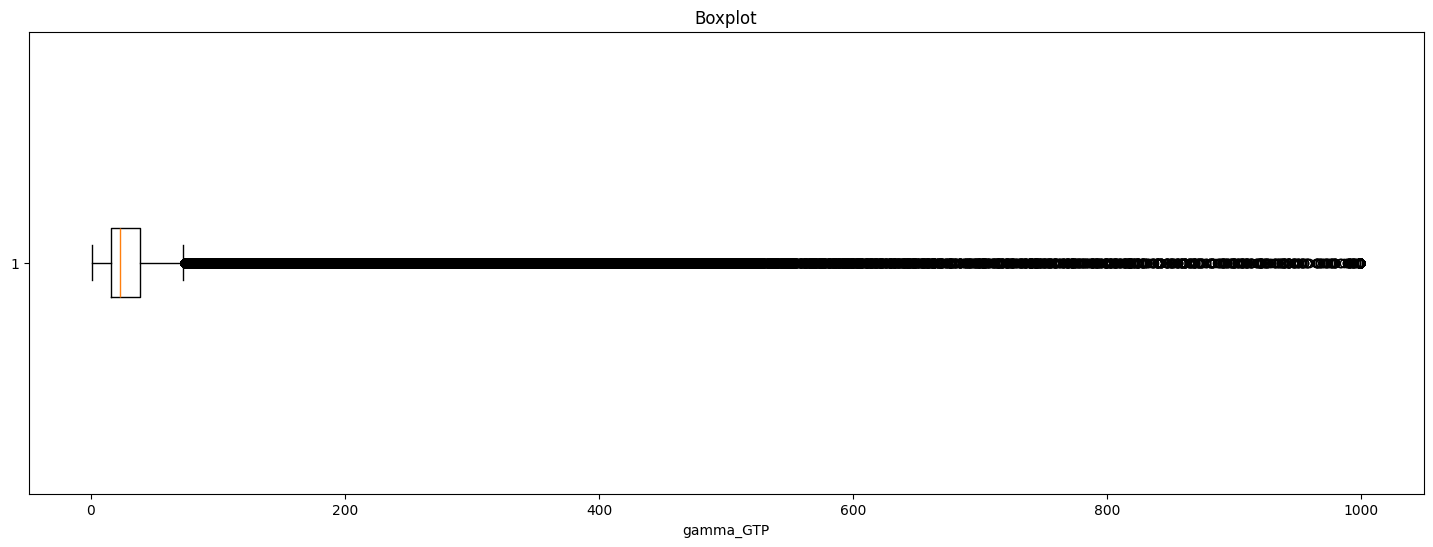

In [10]:
# Darstellen der Verteilung der jeweiligen Spalten:

    # Filtern der Spalten, die mehr als 30 unterschiedliche Werte enthalten:

dataset_columns_more = dataset.loc[:, dataset.apply(pd.Series.nunique) > 30]

column_names_more = dataset_columns_more.columns.values.tolist()

for column in column_names_more:
    boxplot_chart(column)

Die bereits erwähnten Auffälligkeiten zeigen sich auch über die Visualisierung wieder auf.

- Ein Hüftumfang von 999 cm ist in der semantischen Interpretation eindeutig zu eliminieren. Es handelt sich um einen Datenfehler.
- Die maximalen Werte der Spalten Sehkraft_links und Sehkraft_rechts (9.9) stehen für erblindete Probanden. Sie werden auf Grund der starken Abweichung vom Mittelwert eliminiert.

Da die sehr starken Abweichungen der folgenden Spalten nicht interpretiert und aus medizinischer Sicht nicht legitimiert werden können, werden sie aus dem Datensatz herausgefiltert.
Dieser Schritt wurde auch von der medizinischen Expertin, die im Rahmen des Projektes befragt wurde, für richtig empfunden.

- Nüchterner Blutzucker
- Totale Cholesterin
- HDL_Cholesterin
- LDL_Cholesterin
- Triglycerid
- Serum_Kreatinin
- SGOT_AST
- SGOT_ALT
- gamma_GTP

Formale Aspekte:

- Die Spalten Trinker & Geschlecht vom Datentyp 'object' werden zu einer Ganzzahl umformatiert.
- Ein Identifier für jede Zeile des Datensatzes wird nicht benötigt.

Diese werden in der Dokumentation genauer erläutert und bei Bedarf im folgenden Abschnitt bereinigt.

## 3. Data Preparation 

Zunächst werden die Datentypen der Spalten Geschlecht und Trinker zu Zahlenwerten transformiert.

In der Spalte Geschlecht nimmt die Ausprägung 'Male' dann den Wert 1 und 'Female' den Wert 0 an.

In der Spalte Trinker wird das 'Y' (für Yes) zu 1 und das 'N' (für No) zu 0.

In [11]:
# Transformieren der Spalte Geschlecht:

dataset['Geschlecht'] = dataset['Geschlecht'] == 'Male'
dataset['Geschlecht'] = dataset['Geschlecht'].astype(int)


# Transformieren der Spalte Trinker:

dataset['Trinker'] = dataset['Trinker'] == 'Y'
dataset['Trinker'] = dataset['Trinker'].astype(int)

Zudem werden hier neue Features definiert und dem Datensatz hinzugefügt.

In [12]:
# Hinzufügen der Spalte Body-Mass-Index:

BMI = dataset["Gewicht"].astype(np.float64) / ((dataset["Größe"].astype(np.float64) / 100) * (dataset["Größe"].astype(np.float64) / 100))

dataset["Body-Mass-Index"] = round(BMI, 2)

Die im Abschnitt Data Understanding identifizierten auffälligen Datenpunkte werden nun bereinigt.

Die hierbei ausgewählten Filtergrößen wurden gemeinsam mit der medizinischen Expertin festgesetzt.

Da unser Datensatz sehr groß ist (991.346 Zeilen), können fehlerhafte Datenpunkte einfach herausgefiltert werden. Dennoch sollte die Anzahl der Datenpunkte betrachtet und evaluiert werden.

In [13]:
# Ausgabe der Anzahl der fehlerhaften Datenpunkte:

print('Anzahl auffällige Datenpunkte Hüftumfang: ' + str(len(dataset[dataset['Hüftumfang'] == 999])))

print('Anzahl auffällige Datenpunkte Sehkraft_links: ' + str(len(dataset[dataset['Sehkraft_links'] == 9.9])))

print('Anzahl auffällige Datenpunkte Sehkraft_rechts: ' + str(len(dataset[dataset['Sehkraft_rechts'] == 9.9])))

print('Anzahl auffällige Datenpunkte Nüchterner Blutzucker: ' + str(len(dataset[dataset['Nüchterner Blutzucker'] > 700])))

print('Anzahl auffällige Datenpunkte Totale Cholesterin: ' + str(len(dataset[dataset['Totale Cholesterin'] > 1000])))

print('Anzahl auffällige Datenpunkte HDL_Cholesterin: ' + str(len(dataset[dataset['HDL_Cholesterin'] > 3000])))

print('Anzahl auffällige Datenpunkte LDL_Cholesterin: ' + str(len(dataset[dataset['LDL_Cholesterin'] > 3000])))

print('Anzahl auffällige Datenpunkte Triglycerid: ' + str(len(dataset[dataset['Triglycerid'] > 5000])))

print('Anzahl auffällige Datenpunkte Serum_Kreatinin: ' + str(len(dataset[dataset['Serum_Kreatinin'] > 50])))

print('Anzahl auffällige Datenpunkte SGOT_AST: ' + str(len(dataset[dataset['SGOT_AST'] > 3000])))

print('Anzahl auffällige Datenpunkte SGOT_ALT: ' + str(len(dataset[dataset['SGOT_ALT'] > 3000])))

Anzahl auffällige Datenpunkte Hüftumfang: 57
Anzahl auffällige Datenpunkte Sehkraft_links: 3118
Anzahl auffällige Datenpunkte Sehkraft_rechts: 3111
Anzahl auffällige Datenpunkte Nüchterner Blutzucker: 6
Anzahl auffällige Datenpunkte Totale Cholesterin: 17
Anzahl auffällige Datenpunkte HDL_Cholesterin: 1
Anzahl auffällige Datenpunkte LDL_Cholesterin: 1
Anzahl auffällige Datenpunkte Triglycerid: 4
Anzahl auffällige Datenpunkte Serum_Kreatinin: 19
Anzahl auffällige Datenpunkte SGOT_AST: 6
Anzahl auffällige Datenpunkte SGOT_ALT: 5


In [14]:
# Ausgabe der Anzahl der fehlerhaften Datenpunkte gesamt:

filter_Hüftumfang = dataset['Hüftumfang'] == 999
filter_Sehkraft_links = dataset['Sehkraft_links'] == 9.9
filter_Sehkraft_rechts = dataset['Sehkraft_rechts'] == 9.9
filter_Nüchterner_Blutzucker = dataset['Nüchterner Blutzucker'] > 700
filter_Totales_Cholesterin = dataset['Totale Cholesterin'] > 1000
filter_HDL_Cholesterin = dataset['HDL_Cholesterin'] > 3000
filter_LDL_Cholesterin = dataset['LDL_Cholesterin'] > 3000
filter_Triglycerid = dataset['Triglycerid'] > 5000
filter_Serum_Kreatinin = dataset['Serum_Kreatinin'] > 50
filter_SGOT_AST = dataset['SGOT_AST'] > 3000
filter_SGOT_ALT = dataset['SGOT_ALT'] > 3000

filtered_dataset = dataset[filter_Hüftumfang | filter_Sehkraft_links | filter_Sehkraft_rechts | filter_Nüchterner_Blutzucker | filter_Totales_Cholesterin | filter_HDL_Cholesterin | filter_LDL_Cholesterin | filter_Serum_Kreatinin | filter_Triglycerid | filter_SGOT_AST | filter_SGOT_ALT]

print(len(filtered_dataset))

5854


Von den 991.346 Zeilen werden somit lediglich 5.833 herausgefiltert.

In [15]:
# Ausgabe der Anzahl der fehlerhaften Datenpunkte gesamt:

filter_Hüftumfang = dataset['Hüftumfang'] != 999
filter_Sehkraft_links = dataset['Sehkraft_links'] != 9.9
filter_Sehkraft_rechts = dataset['Sehkraft_rechts'] != 9.9
filter_Nüchterner_Blutzucker = dataset['Nüchterner Blutzucker'] <= 700
filter_Totales_Cholesterin = dataset['Totale Cholesterin'] <= 1000
filter_HDL_Cholesterin = dataset['HDL_Cholesterin'] <= 3000
filter_LDL_Cholesterin = dataset['LDL_Cholesterin'] <= 3000
filter_Triglycerid = dataset['Triglycerid'] <= 5000
filter_Serum_Kreatinin = dataset['Serum_Kreatinin'] <= 50
filter_SGOT_AST = dataset['SGOT_AST'] <= 3000
filter_SGOT_ALT = dataset['SGOT_ALT'] <= 3000

dataset = dataset[filter_Hüftumfang & filter_Sehkraft_links & filter_Sehkraft_rechts & filter_Nüchterner_Blutzucker & filter_Totales_Cholesterin & filter_HDL_Cholesterin & filter_LDL_Cholesterin & filter_Serum_Kreatinin & filter_Triglycerid & filter_SGOT_AST & filter_SGOT_ALT]

print(len(dataset))

985492


Nun müsste der Datensatz erneut auf Auffälligkeiten untersucht werden, um zu validieren, dass alle fehlerhaften Daten eliminiert wurde.

Im Rahmen der Umsetzung der Anforderungen erfolgte dieser Schritt iterativ, bis wir zum hier dargestellten Punkt kamen. Deshalb wird auf einen erneuten iterativen Ansatz innerhalb dieser Projektmappe verzichtet. 

Da es in diesem Use-Case um die Klassifizierung der Raucher geht, können zudem Spalten eliminiert werden, die nicht mit diesem Feature korrelieren.

Durch die Transformation der Datentypen der Spalten Geschlecht und Trinker kann folgend eine Korrelationsmatrix dargestellt werden.

In [16]:
# Funktion zum Darstellen der Korrelation der Werte mehrerer Spalten:

def corrmap(columns):
    plt.figure(figsize=(20, 18))
    data = dataset[columns]
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm")

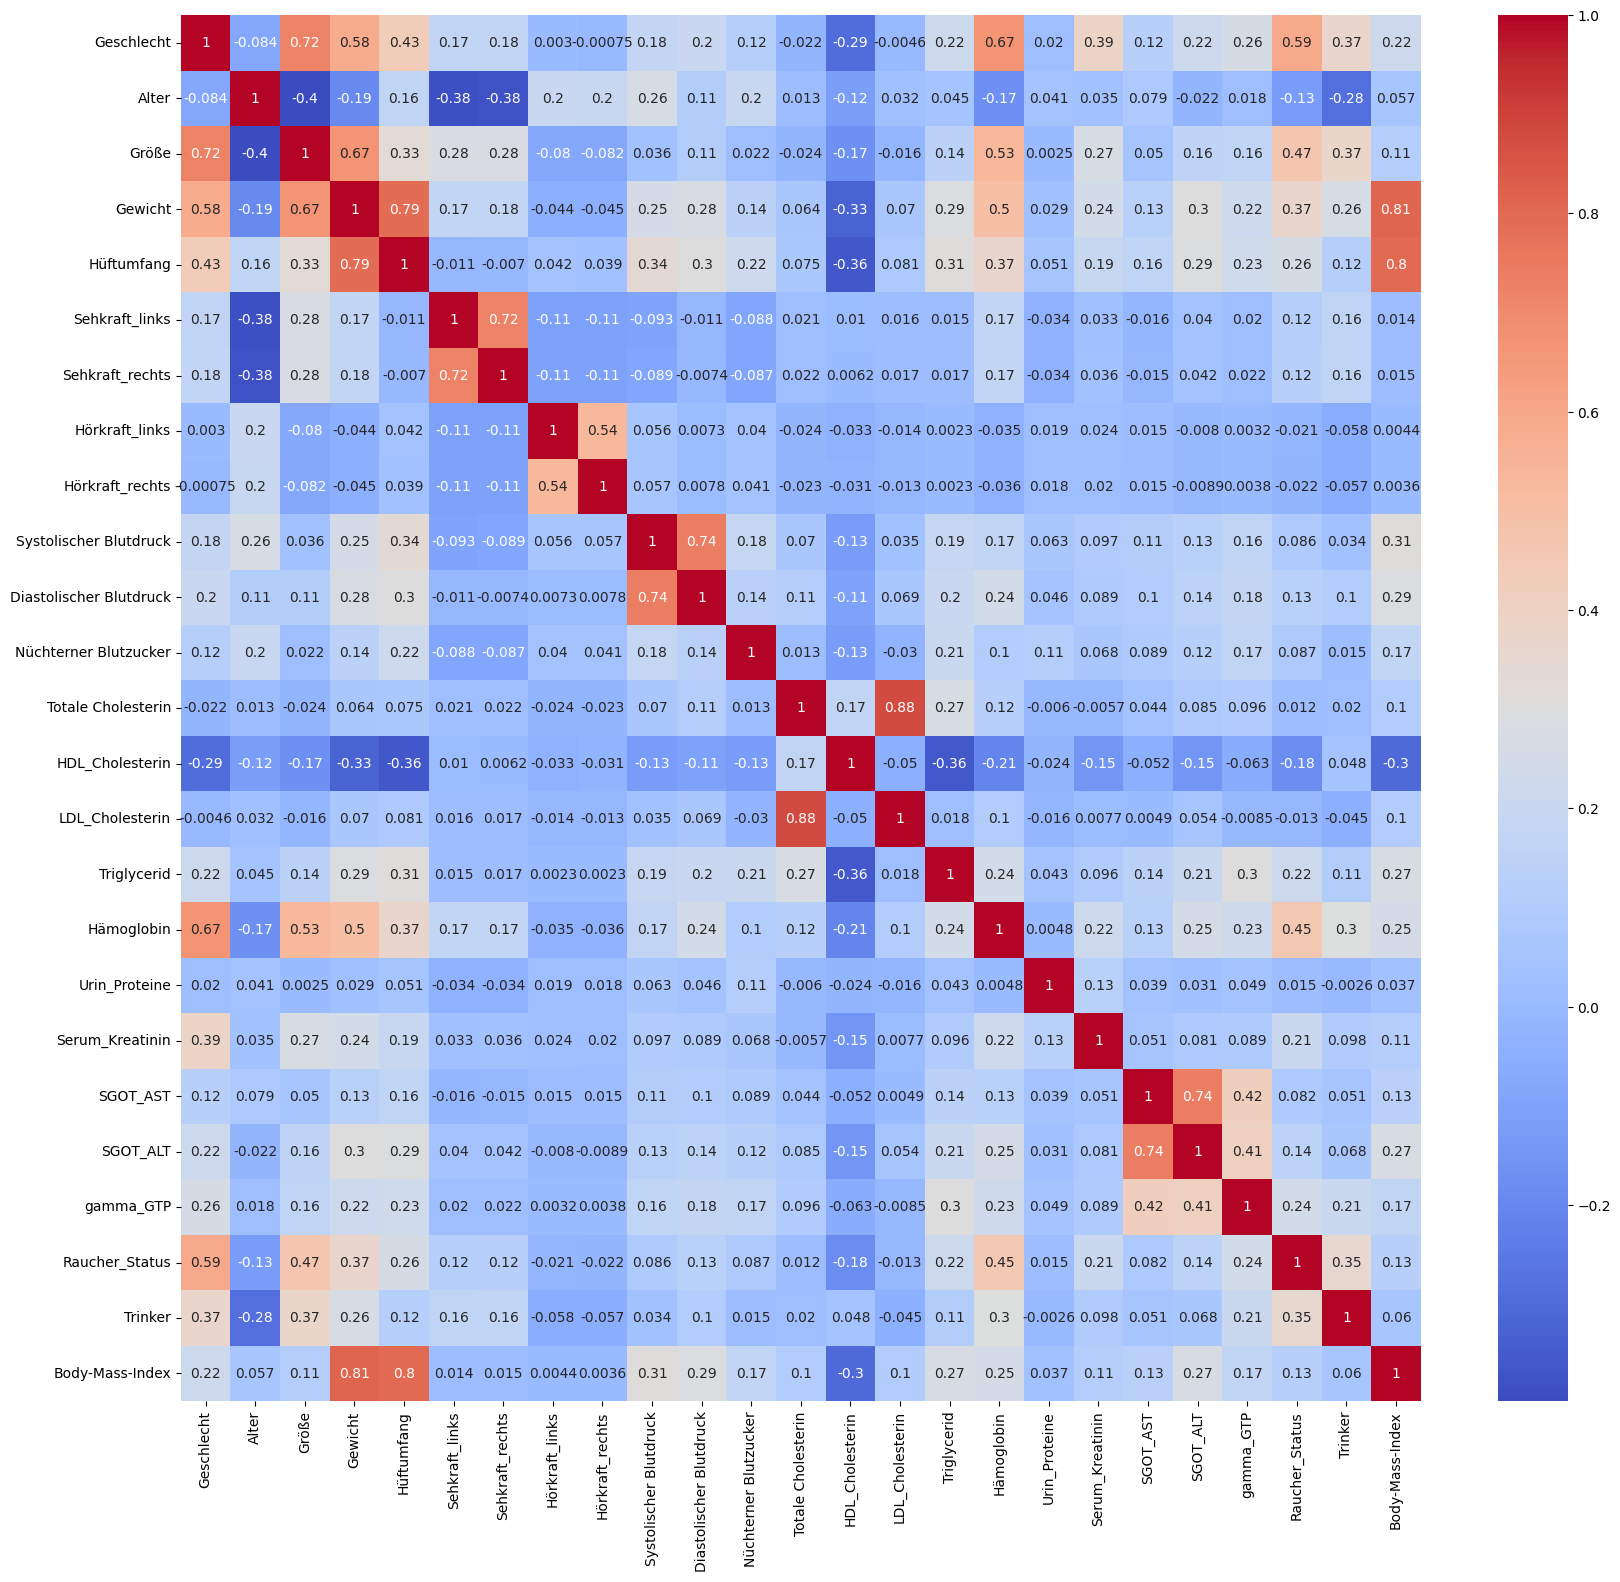

In [17]:
column_names = dataset.columns.values.tolist()

corrmap(column_names)

Die folgenden Spalten korrelieren nur sehr gering mit dem Feature Raucher_Status und werden deshalb eliminiert.

- Sehkraft_links 
- Sehkraft_rechts 
- Hörkraft_links 
- Hörkraft_rechts 
- Systolischer Blutdruck 
- Diastolischer Blutdruck 
- Nüchterner Blutzucker 
- Totale Cholesterin 
- HDL_Cholesterin 
- LDL_Cholesterin 
- Urin_Proteine 
- Serum_Kreatinin 
- SGOT_AST 
- SGOT_ALT 
- Body-Mass-Index

Auch dieses Vorgehen wurde gemeinsam mit der medizinischen Fachexpertin besprochen.
Hier konnte diese jedoch nur bedingt Aussagen über die Korrektheit des Vorgehens machen. 

Eine weitere Entscheidungsgrundlage hier war die von uns gesammelte Erfahrung bei der Entwicklung der Anforderungsnotebooks.

In [18]:
# Eliminieren der Spalten:

dataset = dataset.drop(columns=['Sehkraft_links', 'Sehkraft_rechts', 'Hörkraft_links', 'Hörkraft_rechts', 'Systolischer Blutdruck', 'Diastolischer Blutdruck', 'Nüchterner Blutzucker', 'Totale Cholesterin', 'HDL_Cholesterin', 'LDL_Cholesterin', 'Urin_Proteine', 'Serum_Kreatinin', 'SGOT_AST', 'SGOT_ALT', 'Body-Mass-Index'])

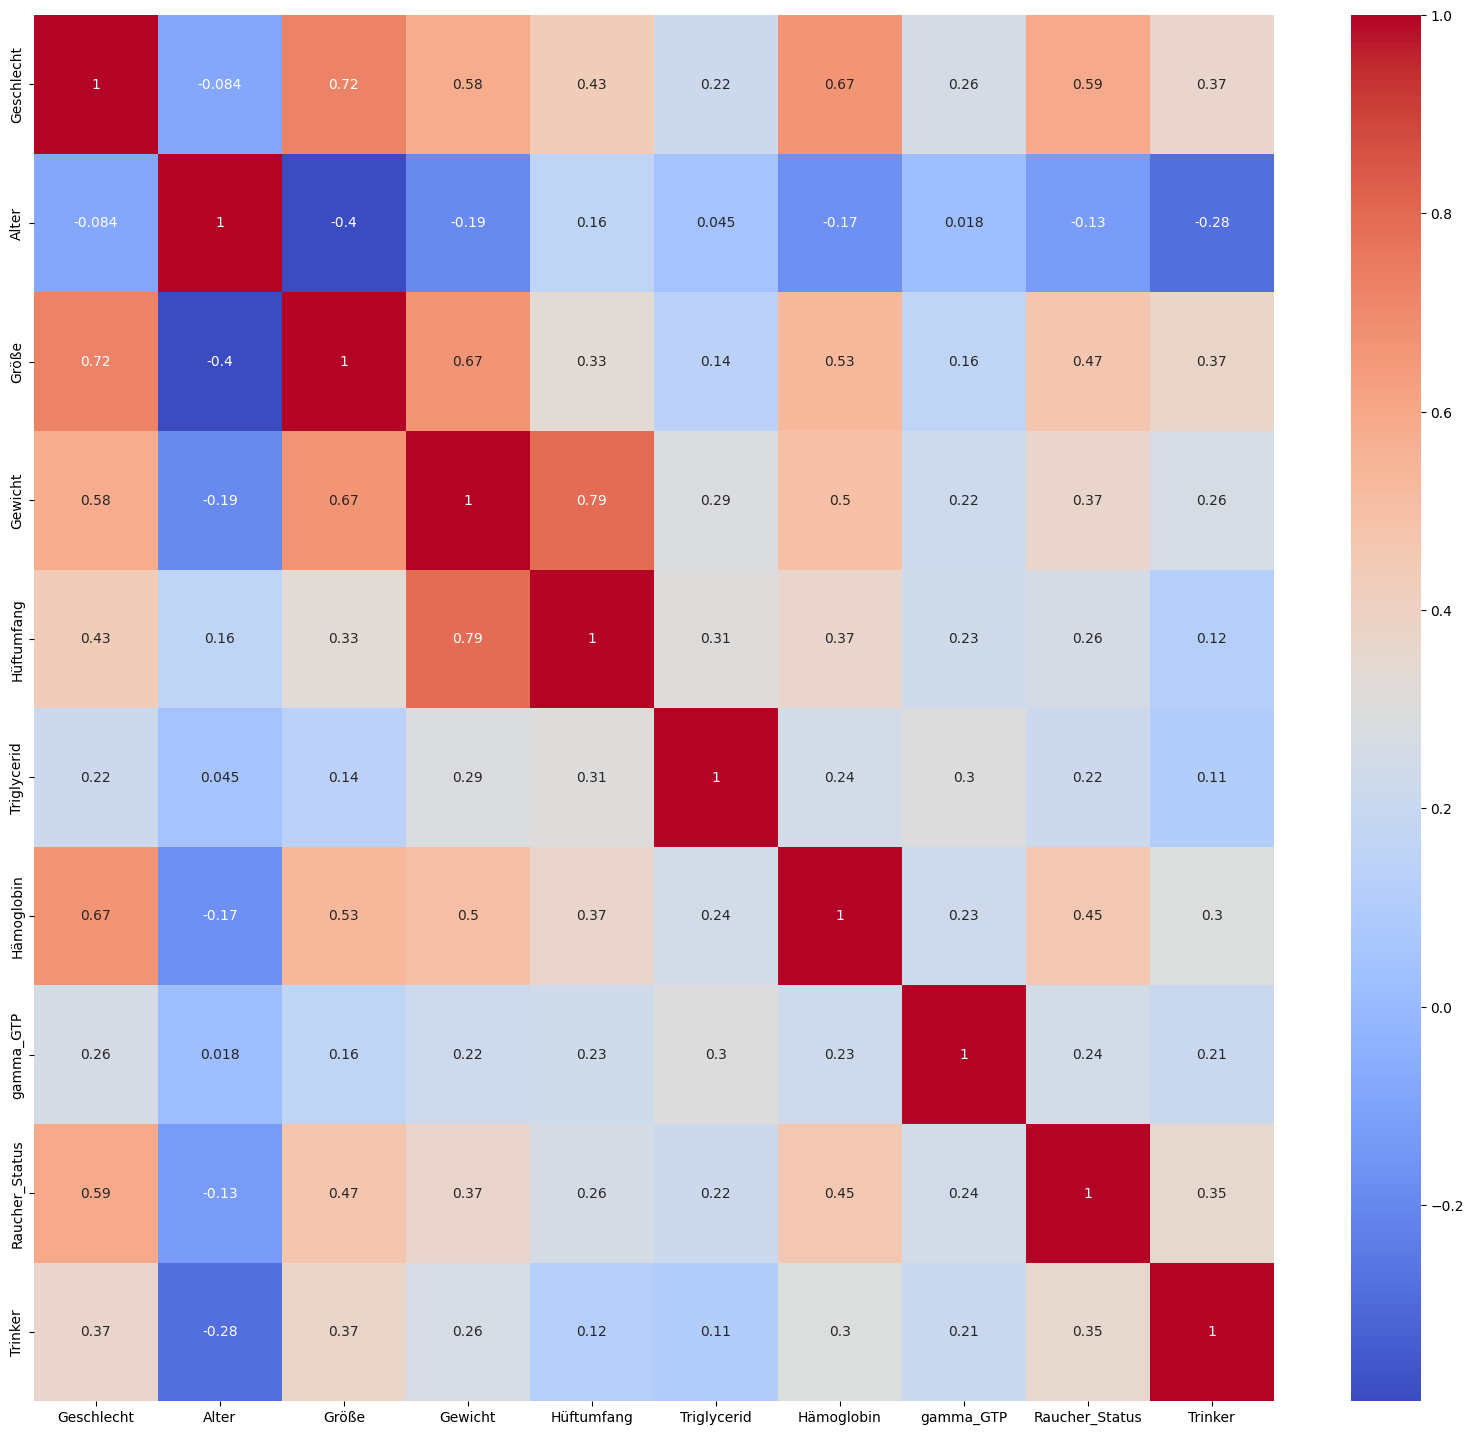

In [19]:
# Erneute Darstellung der Korrelation:

column_names = dataset.columns.values.tolist()

corrmap(column_names)

Nun sollten die Datensätze erneut auf Auffälligkeiten geprüft werden.

Im Rahmen dieser Projektarbeit verlief der gesamte Entwicklungsprozess iterativ. Dies hier darzustellen würde jedoch für eine unübersichtliche Struktur sorgen, weshalb darauf verzichtet wird.

Das Geschlecht ist mit einer Korrelation zum Raucher_Status mit 0,59 ein wesentlicher Einfluss auf diesen. Es wird somit auch im Klassifikationsalgorithmus berücksichtigt, wodurch eine Aufteilung der Daten auf Männer und Frauen für dieses Modell nicht notwendig ist.

## 4. Modeling

Aus der Sicht einer Versicherung besteht bei ehemaligen Rauchern ein nahezu gleiches Gesundheitsrisiko wie bei aktiven Rauchern.

Für die Einordnung der Kunden in Versicherungskohorten ergibt es sich deshalb, diese Raucherstati zusammenzulegen.

In [20]:
# Vereinheitlichung der Raucherstati 2 (ehemalige Raucher) & 3 (aktive Raucher):

dataset['Raucher_Status'] = dataset['Raucher_Status'].replace(3,2)

Zunächst wird hier die Verteilung der Zielklassen betrachtet, um ein eventuell benötigtes Resampling festzustellen.

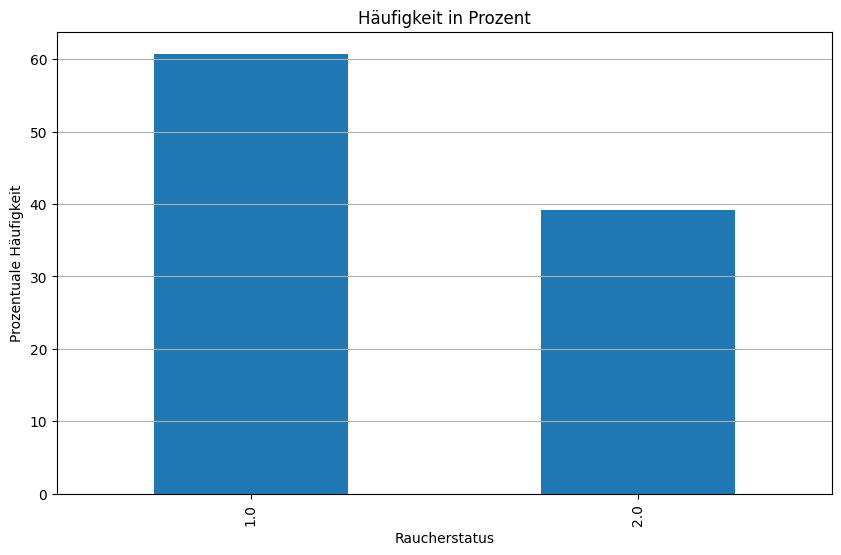

In [21]:
# Berechne relative Häufigkeit der Zielwerte in Prozent 

frequency = (dataset['Raucher_Status'].sort_values().value_counts(sort=False) / len(dataset)) * 100 

# Balkendiagramm über die Verteilung 

plt.figure(figsize=(10, 6)) 
frequency.plot(kind='bar') 
plt.xlabel('Raucherstatus') 
plt.ylabel('Prozentuale Häufigkeit') 
plt.title('Häufigkeit in Prozent') 
plt.grid(axis='y') 
plt.show()

Der Anteil an Nicht-Rauchern ist rund 50 % größer als der Anteil der aktiven und ehemaligen Rauchern, weshalb die Daten folgend durch eine Undersampling bereinigt werden.

Dieses Undersampling minimiert zudem das Rauschen in den Daten.

Random under-sampling:
Raucher_Status
1.0    386651
2.0    386651
Name: count, dtype: int64


<Axes: title={'center': 'Anzahl je Raucher_Status'}, xlabel='Raucher_Status'>

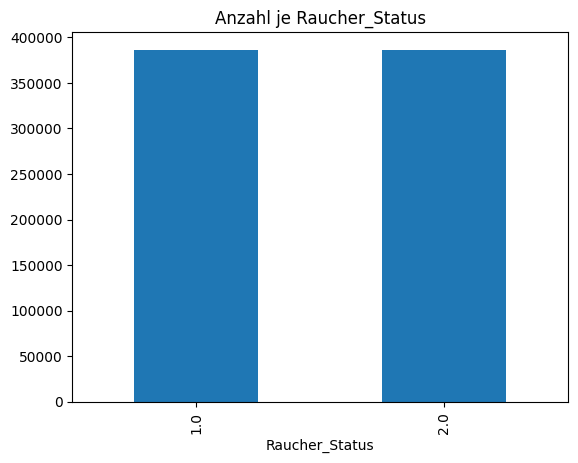

In [22]:
# Undersampling der Daten:

count_class_0, count_class_1 = dataset['Raucher_Status'].sort_values().value_counts()

# Aufteilen in Zielklassen:

class_0 = dataset[dataset['Raucher_Status'] == 1]
class_1 = dataset[dataset['Raucher_Status'] == 2]


class_0_under = class_0.sample(count_class_1)
data_undersample = pd.concat([class_0_under, class_1], axis=0)

print('Random under-sampling:')
print(data_undersample['Raucher_Status'].value_counts())

data_undersample['Raucher_Status'].value_counts().plot(kind='bar', title='Anzahl je Raucher_Status')

In [23]:
# Aufteilen der Daten in Trainings- und Testdaten:

model_X_train, model_X_test, model_y_train, model_y_test = train_test_split(data_undersample.drop(columns=['Raucher_Status']), data_undersample['Raucher_Status'], test_size=0.2, random_state=42)

model_X_train

,Geschlecht,Alter,Größe,Gewicht,Hüftumfang,Triglycerid,Hämoglobin,gamma_GTP,Trinker
875970,1,55,160,60,82.0,237.0,15.6,97.0,1
303007,1,50,160,65,82.0,178.0,16.3,82.0,1
765084,1,40,165,65,80.1,60.0,15.0,53.0,1
129500,1,40,175,90,104.0,110.0,15.3,34.0,1
574265,1,60,170,70,78.0,86.0,16.0,18.0,0
...,...,...,...,...,...,...,...,...,...
790549,0,40,160,65,75.0,147.0,13.9,34.0,0
460780,0,60,150,60,87.0,132.0,15.5,18.0,0
820563,0,60,150,50,79.0,177.0,12.4,36.0,0
729340,1,65,155,55,76.0,95.0,13.1,39.0,0


Nun kann das Modell trainiert und die Modellmetriken ausgewertet werden.

In [24]:
softmax_model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)
softmax_model.fit(model_X_train, model_y_train)

c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')

Accuracy: 0.83


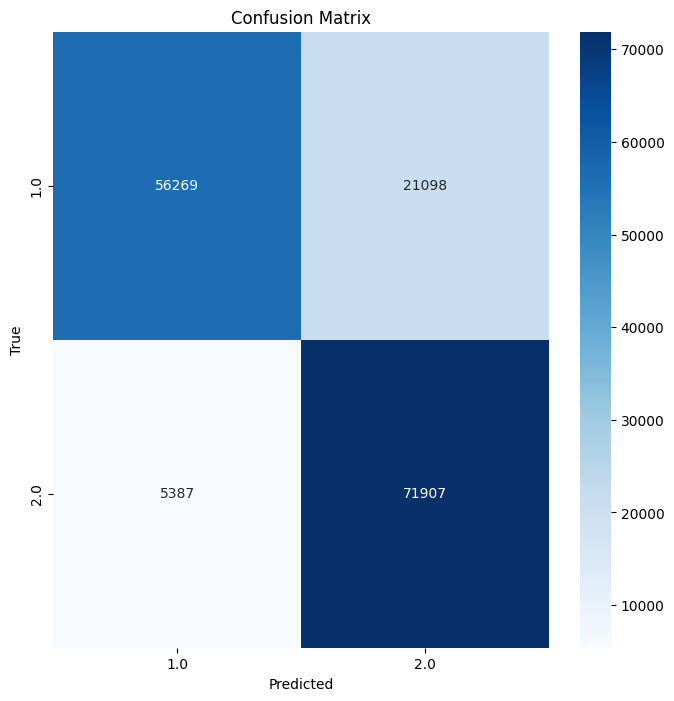

In [25]:
# Vorhersagen auf dem Testset machen (nur für die selektierten Features)

y_pred_model = softmax_model.predict(model_X_test)

# Validierung
accuracy = accuracy_score(model_y_test, y_pred_model)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix erstellen und anzeigen:

cm = confusion_matrix(model_y_test, y_pred_model)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['Raucher_Status'].unique() , yticklabels=dataset['Raucher_Status'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Precision berechnen:

precision = precision_score(model_y_test, y_pred_model, average='weighted')
print(f'Precision: {precision:.2f}')

# Recall berechnen:

recall = recall_score(model_y_test, y_pred_model, average='weighted')
print(f'Recall weighted: {recall:.2f}')

# F1 Score berechnen:

f1 = f1_score(model_y_test, y_pred_model, average='weighted')
print(f'F1 score: {f1:.2f}')

Precision: 0.84
Recall weighted: 0.83
F1 score: 0.83


Mit einer Accuracy von 83%, einer Precision von 84 %, einem Recall von 83 % und einem F1 Score von 83 % kann das Modell definitiv verwendet werden, um die gemachten Angaben der Versicherungskunden bei der Befragung zum Raucherstatus zu validieren.

Dennoch muss deulich gemacht werden, dass man sich nicht alleine auf die Ausgabewerte des Modells berufen darf.

## 5. Evaluation

Es müssen zudem weitere Evaluationen durchgeführt werden, die im Gesamtbild mit den Modellmetriken interpretiert werden müssen.

##### Frequenzbaseline

Hierfür wird zunächst eine Frequenzbasislinie erstellt, die stets den Wert der am öftesten vorkommenden Klasse voraussagt.

<Axes: title={'center': 'Anzahl je Raucher_Status'}, xlabel='Raucher_Status'>

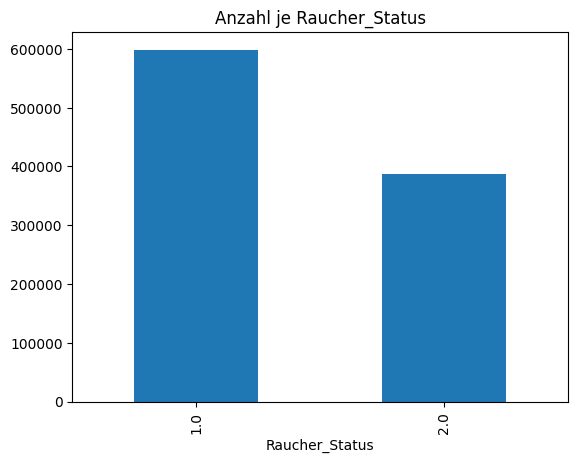

In [27]:
dataset['Raucher_Status'].value_counts().plot(kind='bar', title='Anzahl je Raucher_Status')

Wie in der Grafik zu sehen ist, ist die am häufigsten vorkommende Klasse der Raucherstatus 1 (Nicht-Raucher).

Da die Verteilung dennoch nicht all zu unterschiedlich ist, wird erwartet, dass die Frequenzbasislinie nicht bessere Metriken aufweisen kann als unser Modell.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['Raucher_Status']), dataset['Raucher_Status'], test_size=0.2, random_state=42)

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


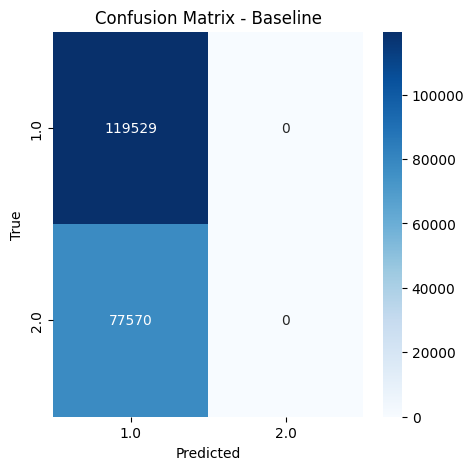

Accuracy (Baseline): 0.61
Precision (Baseline): 0.37
Recall (Baseline): 0.61
F1 score (Baseline): 0.46


In [29]:
# Erstelle ein DummyClassifier mit der Strategie 'most_frequent'
baseline_model = DummyClassifier(strategy='most_frequent')

# Trainiere das Basismodell
baseline_model.fit(X_train, y_train)

# Mache Vorhersagen auf dem Testset
y_pred_baseline = baseline_model.predict(X_test)

# Evaluationsmetriken berechnen
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
precision_baseline = precision_score(y_test, y_pred_baseline, average='weighted')
recall_baseline = recall_score(y_test, y_pred_baseline, average='weighted')
f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted')

# Confusion Matrix erstellen und anzeigen
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['Raucher_Status'].unique(), yticklabels=dataset['Raucher_Status'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Baseline')
plt.show()

# Ausgabe der Metriken
print(f'Accuracy (Baseline): {accuracy_baseline:.2f}')
print(f'Precision (Baseline): {precision_baseline:.2f}')
print(f'Recall (Baseline): {recall_baseline:.2f}')
print(f'F1 score (Baseline): {f1_baseline:.2f}')

Die bereits beschriebene Vermutung, dass die Modellmetriken der Frequenzbaseline schlechter sind als die unseres Modells, hat sich bestätigt. 

Die Accuracy, die Precision, der Recall und der F1-Score sind deutlich schlechter als die Werte unseres Modells.

##### Vergleichsbaseline

Um eine breitere Diversität in der Evaluation zu erreichen, wird zudem folgend ein einfaches Vergleichsmodell trainiert. 

In [30]:
# Aufteilen der Daten in Trainings- und Testdaten:

X_train, X_test, y_train, y_test = train_test_split(data_undersample.drop(columns=['Raucher_Status']), data_undersample['Raucher_Status'], test_size=0.2, random_state=42)

X_train

,Geschlecht,Alter,Größe,Gewicht,Hüftumfang,Triglycerid,Hämoglobin,gamma_GTP,Trinker
875970,1,55,160,60,82.0,237.0,15.6,97.0,1
303007,1,50,160,65,82.0,178.0,16.3,82.0,1
765084,1,40,165,65,80.1,60.0,15.0,53.0,1
129500,1,40,175,90,104.0,110.0,15.3,34.0,1
574265,1,60,170,70,78.0,86.0,16.0,18.0,0
...,...,...,...,...,...,...,...,...,...
790549,0,40,160,65,75.0,147.0,13.9,34.0,0
460780,0,60,150,60,87.0,132.0,15.5,18.0,0
820563,0,60,150,50,79.0,177.0,12.4,36.0,0
729340,1,65,155,55,76.0,95.0,13.1,39.0,0


In [31]:
# Erstellen der Pipeline:

baseline_pipeline = Pipeline(steps=[
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'), threshold='mean')),
                ('classifier', GaussianNB())])

baseline_pipeline.fit(X_train, y_train)

# Lerner auf den Testdaten evaluieren

dev_labels = baseline_pipeline.predict(X_test)

print(classification_report(y_test, dev_labels))

c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

         1.0       0.91      0.73      0.81     77367
         2.0       0.77      0.93      0.84     77294

    accuracy                           0.83    154661
   macro avg       0.84      0.83      0.83    154661
weighted avg       0.84      0.83      0.83    154661



Im Rahmen der Evaluation wurden mehrere solche Pipelines entwickelt, die mit unterschiedlichen Parametern ausgeführt wurden. Das beste Ergebnis lieferte die zuvor dargestellte Pipeline, die mit undergesampelten Daten auf dem Gaussian Naive Bayes Classifier ausgeführt wurde.

Die Metriken dieser Vergleichsbaseline entsprechen genau den Metriken unseres Modells.

Da wir einige Vergleichsmodelle trainiert haben und dieses das mit den besten Metriken war, vermuten wir, dass unser Modell (gemeinsam mit dem Vergleichsmodell) die bestmögliche Performance erreicht hat.

Kritisch müsste dies betrachtet werden, wenn die Metriken der Vergleichsbaseline besser wären als die unseres Modells.

##### Over- & Underfitting

Zudem kann geprüft werden, ob unser Modell zu Over- oder Underfitting neigt. Dies geschieht in der folgenden Codezelle.

c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 3.233 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 6.466 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 9.699 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 12.932 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 16.164 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 19.397 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 22.63 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 25.863 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 29.096 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 32.329 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 35.562 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 38.795 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 42.028 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 45.26 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 48.493 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 51.726 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 54.959 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 58.192 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 61.425 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 64.658 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 67.891 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 71.124 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 74.357 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 77.589 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 80.822 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 84.055 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 87.288 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 90.521 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 93.754 %


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Execution: 96.987 %


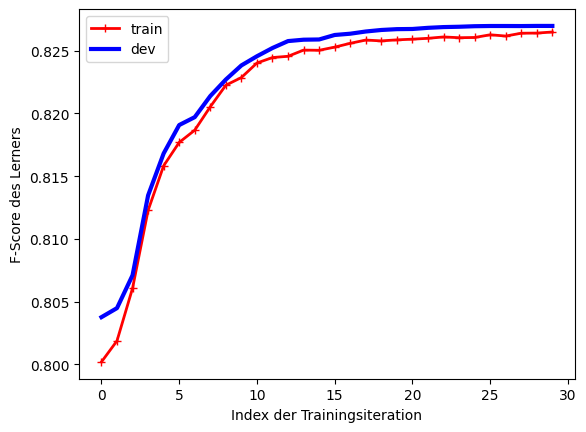

In [32]:
# Lernkurve plotten (in 20.000-er Schritten, da der Datensatz sehr groß ist und kleinere Schritte zu einem Timeout führen):

importlib.reload(init_notebook)
init_notebook.plot_learning_curves(softmax_model, model_X_train, model_y_train, model_X_test, model_y_test, 20000)

Aus der [Grafik](Anforderungen/Logs/Projektmappe/Lernkurve.png) wird ersichtlich, dass weder Over- noch Underfitting vorherrscht:

> Liegen die Maximalwerte nah beieinander und der Maximalwert ist auch noch relativ niedrig (im Vergleich zu den Baselines), liegt wahrscheinlich Underfitting vor.

Die Maximalwerte liegen zwar nahe beieinander (~ 0.1 Prozentpunkte Differenz), jedoch sind diese in Relation zu den Baselines nicht niedrig (F1-Score etwa 0.3 bis 0.4 Prozentpunkte geringer als bei unserer besten Vergleichsbaseline (83 %)). 

> Ein Modell, das auf den Trainingsdaten wenig Fehler macht, aber auf den Entwicklungsdaten konsistent deutlich schlechter abschneidet, zeigt eher Overfitting.

Da der Unterschied zwischen den Trainungs- und Entwicklungsdaten nicht wesentlich ist, liegt auch kein Overfitting vor.

In [ ]:
# Der Datensatz is sehr homogen

# Grafiken: was sagen se aus?

##### Interpretation

Auf Basis der durchgeführten Untersuchungen sowie der Modellmetriken kann das Modell nun interpretiert werden.  

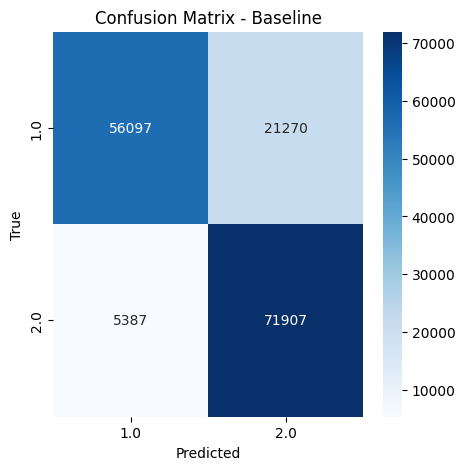

Accuracy (Baseline): 0.83
Precision (Baseline): 0.84
Recall (Baseline): 0.83
F1 score (Baseline): 0.83


In [33]:
# Mache Vorhersagen auf dem Testset
y_pred = softmax_model.predict(X_test)

# Evaluationsmetriken berechnen
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion Matrix erstellen und anzeigen
cm_baseline = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['Raucher_Status'].unique(), yticklabels=dataset['Raucher_Status'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Baseline')
plt.show()

# Ausgabe der Metriken
print(f'Accuracy (Baseline): {accuracy:.2f}')
print(f'Precision (Baseline): {precision:.2f}')
print(f'Recall (Baseline): {recall:.2f}')
print(f'F1 score (Baseline): {f1:.2f}')

Durch den Vergleich unseres Modells zu den Baselines und auch zu den Modellen auf Kaggle konnte festgestellt werden, dass dieses kaum genauer werden kann als es aktuell ist.

Die Confusion-Matrix zeigt, dass falsche Voraussagen tendenziell eher bei Raucherstatus True = 1 & Predicted = 2 auftauchen. Das bedeutet, dass vorausgesagt wird, dass ein Proband Raucher oder ehemaliger Raucher ist, obwohl er nicht raucht und nie geraucht hat. 

Es muss daher bei der Auswertung stets im Hinterkopf behalten werden, dass das Modell nicht perfekt ist und die Ausgaben kritisch hinterfragt werden müssen, da lediglich eine Genauigkeit von rund 83 % vorherrscht. 

Aus dem vorherigen Abschnitt ist zu sehen, dass das Modell weder zu Over-, noch zu Underfitting neigt und somit bedenkenlos auf neue Daten angewandt werden kann.

Es scheint, als wäre das Rauschen in den Daten durch das Undersampling vor dem Training des Modells reduziert worden.

## 6. Deployment

Da das Modell nun fertig trainiert und evaluiert wurden, müssten sie nun dem Business-User zur Verfügung gestellt werden.
Hierfür gibt es mehrere Möglichkeiten. 

Eine Möglichkeit wäre es, die Modelle über die 'Azure Machine Learning' - Plattform von Microsoft zu hosten, sodass sie über einen REST-Endpunkt verfügbar gemacht werden können.

Basierend auf diesem Endpunkt könnte dann eine Web-Anwendung entwickelt werden, in der die benötigten Features eingetragen werden können, sodass dann das Ergebnis der Klassifikation zurückgegeben wird.

Ein weiterer Aspekt, den es hierbei zu Berücksichtigen gibt is MLOps.
Hierbei geht es um die Maintainance der Modelle und deren Verfügbarkeit.

Es muss darauf geachtet werden, dass die Modelle dem aktuellen Stand der Daten entsprechen, was bedeutet, dass diese immer wieder neu trainiert werden sollten, sodass sich die Genauigkeit über die Zeit hält oder erhöht.

Zudem sollten sie stets verfügbar sein, wenn sie von einem Anwender benötigt werden.

In jedem Fall sollte das Modell jedoch persistiert werden, was im folgenden Schritt geschieht.

In [ ]:
# Speichern des Modells:

joblib.dump(softmax_model, 'Modelle/Projektmappe/softmax_model.joblib')